*DIABETES ANALYSIS INDEX*
===
- [1.Correlations](#1.Correlations)
    - [1.1 Pearson Correlation](#1.1-Pearson-Correlation)
    - [1.2 Distance Correlation](#1.2-Distance-Correlation)
- [2.Features distributions exploration](#2.Features-distributions-exploration)
    - [2.1 BMI](#2.1-BMI)
    - [2.2 S1](#2.1-S1)
    - [2.3 S2](#2.1-S2)
    - [2.4 S3](#2.1-S3)
- [3.Features Transformation](#3.Feature-Transformation)
- [4.Outliers](#4.Outliers)
    - [4.1 Quantile method](#4.1-Quantile-method)
    - [4.2 Mahalanobis distance and chi squared method](#4.2-Mahalanobis-distance-and-chi-squared-method)
- [5.Hyperparameter Tuning](#5.Hyperparameter-Tuning)
    - [5.1 Used Metrics](#5.1-Used-Metrics)
- [6.Feature Importances](#6.Feature-Importances)
- [7.Bagging and Boosting](#7.Bagging-and-Boosting)
- [8.Model convergence results](#8.Model-convergence-results)
    - [8.1 Parameter C](#8.1-Parameter-C)
    - [8.2 Parameter Gamma](#8.2-Parameter-Gamma)
    - [8.3 Parameter Epsilon](#8.3-Parameter-Epsilon)
- [9.Conclusions](#9.Conclusions)



In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import mahalanobis
from dcor import distance_correlation
from scipy.stats import chi2
import math
import warnings

from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,  StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
import os
import re
import pickle
import sys
#plotly.py is an interactive, open-source, and JavaScript-based graphing library for Python. 
#plotly.py is Built on top of plotly.js  
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec





# Set option to display all the dataset rows in console view
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [20]:
# Load dataset from Sklearn
b_data=load_diabetes(return_X_y=False, as_frame=False)
np_data = np.c_[b_data.data, b_data.target]
columns = np.append(b_data.feature_names, ["target"])
df=pd.DataFrame(np_data, columns=columns)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [22]:
df.describe()

age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.156131e-01 -1.023071e-01 -7.639450e-02 -1.260971e-01 -1.377672e-01   
25%   -3.035840e-02 -3.511716e-02 -3.949338e-02 -3.324559e-02 -3.317903e-02   
50%   -3.819065e-03 -6.584468e-03 -2.592262e-03 -1.947171e-03 -1.077698e-03   
75%    2.984439e-02  2.931150e-02  3.430886e-02  3.243232e-02  2.791705e-02   
max    1.987880e-01  1.811791e-01  1.852344e-01  1.335973e-01  1.356118e-01   

           target  
count  442.000000  
mean   152.133484  
std     77.093005  
min     25.000000  
25%     87.000000  
50%    140.500000  
75%    211.500000  
max    346.000000

1.Correlations
===

In [23]:
class Correlations():
    def __init__(self, df, corr_type):
        self.df = df
        self.corr_type = corr_type
        self.df_heatmap = pd.DataFrame()
        #Check if the object is a dataframe
 
        if isinstance(self.df , pd.DataFrame):  
            if corr_type == "pearson":
                self._pearson()
            elif corr_type == "dist_corr":
                self._dist_corr()
            else:
                print("Please insert the correlation type!")
        else:
                print("Argument df is not a dataframe!")

            
    def _pearson (self ,):
        '''
        Definition:
            Measures only linear relationship between two variables if two variables deviates 
            from the mean proportionally and almost constantly. That limitation is related to the 
            fact that the scaling is done with standard deviation that is AVERAGED deviation from 
            the mean.
        Formula:
            pcor = Cov(x,y)/√(Var(x,x)*Var(y,y)) or 
            pcor = √∑((x - x̄)(y - ȳ)) / √(∑(x - x̄)^2 * ∑(y - ȳ)^2)
        '''
        self.df_heatmap = pd.DataFrame(self.df.corr(method='pearson'))
        return self._plot_corr()

    def _dist_corr(self):
        '''
        Links:
            https://www.freecodecamp.org/news/how-machines-make-predictions-finding-correlations-in-complex-data-dfd9f0d87889/
        Definition:
             
        Formula: 
            dcor = dCov(x,y)/dσ(x)*dσ(y) or 
            dcor = √(1/n^2 * ∑|xi - xj - x̄row - x̄col + x̄tot| * |yi - yj - ȳrow - ȳcol + ȳtot|) / 
                √(1/n^2 * ∑|xi - xj - x̄row - x̄col + x̄tot|^2) * √(1/n^2 * ∑|yi - yj - ȳrow - ȳcol + ȳtot|^2) 
        '''
        self.n_dcor = 0
        self.df_heatmap.index = [self.col_name for self.col_name in self.df.columns]
        for self.i , self.col_name in enumerate(self.df.columns) : 
            for self.j , self.col_shift  in enumerate(df.columns) : 
                self.n_dcor = distance_correlation(x = df[self.col_name], y = df[self.col_shift] , exponent = 1 )
                self.df_heatmap.loc[self.col_name,self.col_shift]=self.n_dcor
        return self._plot_corr()

    def _plot_corr(self):
        self.mask=np.zeros_like(self.df_heatmap)
        self.mask[np.triu_indices_from(self.mask)] = True
        f,ax = plt.subplots(figsize=(8,8),facecolor='white')
        sns.color_palette("rocket", as_cmap=True)  
        sns.heatmap(self.df_heatmap,annot = True,square=True, linewidths=1.5, cmap='rocket',mask=self.mask)
        return self

1.1 Pearson Correlation
---

In this section we will focus on linear correlations and Pearson's is one of them. Here are the main feature of Pearson's approach:
    <ul>  
        <li> it's focused on the delta of each feature's sample point from the feature's mean value </li>
        <li> if the main trends of two coupled features are constantly increasing/decreasing in the same way then similarity matches are found</li>
        <li> comparing each sample point with the mean makes the result very sensitive to outliers</li>
        <li> recommended for data with normal distribution </li>
    </ul>

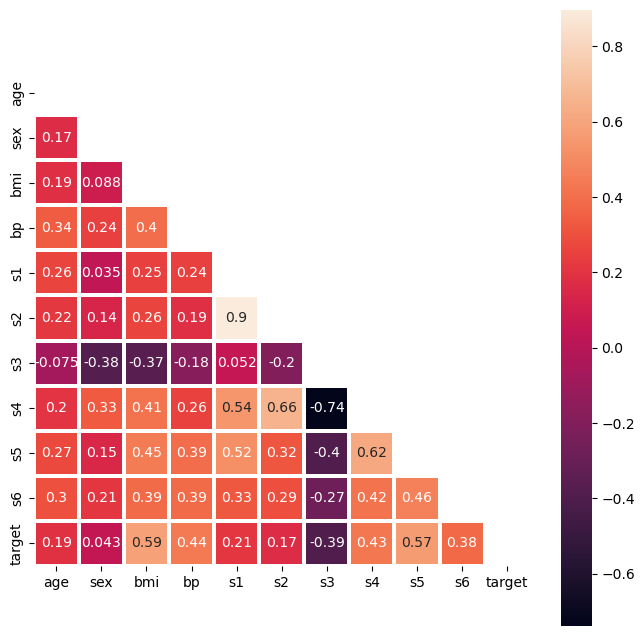

In [24]:
o_pCorr = Correlations(df = df , corr_type = "pearson")

From the graph above that expresses correlation for every feature pairs we can infere that:
<ul>   
    <li><b>s3</b> is moderately correlated with:</li>
        <ul>   
            <li>  <span style='color:#F1C40F'>bmi</span>   </li>
            <li>  <span style='color:orange'>sex</span>   </li>
            <li>  <span style='color:violet'>s5</span>   </li>
            <li>  <span style='color:red'>target</span>   </li>      
        </ul>        
    <li><b>bmi</b> is moderately correlated with:</li>
        <ul>   
            <li>  <span style='color:light blue'>s4</span>   </li>
            <li>  <span style='color:violet'>s5</span>   </li>
            <li>  <span style='color:pink'>s6</span>   </li>
            <li>  <span style='color:red'>target</span>   </li>
        </ul>
    <li><b>bp</b> is moderately correlated with:</li>
        <ul>   
            <li>  <span style='color:violet'>s5</span>   </li>
            <li>  <span style='color:pink'>s6</span>   </li>
            <li>  <span style='color:red'>target</span>   </li>
        </ul>
    <li><b>s1</b> is moderately correlated with:</li>
        <ul>   
            <li>  <span style='color:light blue'>s4</span>   </li>
            <li>  <span style='color:violet'>s5</span>   </li>
        </ul>
</ul>    

The highest correlations are:
<ul>   
    <li><b>s1</b> with:</li>
        <ul>   
            <li>  <span style='color:blue'>s2</span>   </li>
            <li>  <span style='color:light blue'>s4</span>   </li>
            <li>  <span style='color:violet'>s5</span>   </li>
        </ul>
    <li><b>s2</b> with:</li>
        <ul>   
            <li>  <span style='color:light blue'>s4</span>   </li>
        </ul>
    <li><b>s3</b> with:</li>
        <ul>   
            <li>  <span style='color:light blue'>s4</span>   </li>
        </ul>
    <li><b>s4</b> with:</li>
        <ul>   
            <li>  <span style='color:light blue'>s5</span>   </li>
        </ul>
    <li><b>s5</b> with:</li>
        <ul>   
            <li>  <span style='color:red'>target</span>   </li>
        </ul>
</ul>

1.2 Distance Correlation
---

We have now to verify if we can find any non linear correlations between feature pairs. 

Pearson unfortunately recognizes only constant deviation similarity.

The Distance Correlation instead is based on different principles:
    <ul>
        <li> the distance between sample pairs are emphasized, the sample absolute value is not taken into consideration. Therefore sample points relations are emphasized</li>
        <li> outliers sensitivity is less than Pearson's. This is related to the first point of the explanation.</li>
        <li> Distance correlation recognizes complex relations. </li>
        <li> it's useful even for non normal distributions 😁. One reason I think it can be because it doesn't take into account standard deviation.</li>
    </ul>

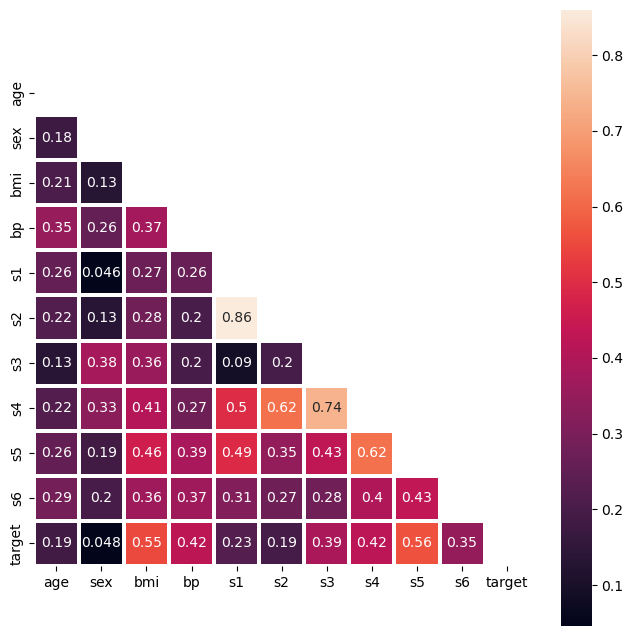

In [25]:
o_dCorr = Correlations(df = df , corr_type = "dist_corr")

From the graph below we can see that the highest correlations are in the same places as Pearson's. This is because Distance correlation detects linear and non-linear correlations.

There is no great discrepancy between Distance Correlation values and Pearson's. This means that feature relations are not too much complex.

2.Features distributions exploration
===

Below I used a Class to manage multiple JointGrid because in case of non standardized variables (not this case) I can see jointplot with different y-axis scales.

In [26]:
class SeabornFig2Grid():
    '''
        This class is used to represent nested complex subplot grid inside the main grid with different y-axis scale
    '''
    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        #Check if the object is a JointGrid     
        if isinstance(self.sg, sns.axisgrid.JointGrid):
            """
            come sopra
            """
            self._movejointgrid()      
        self._finalize()

    
    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        #GridSpecFromSubplotSpec set a plot subgrid inside the main grid where you can configure multiple plots
        self.subgrid = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=self.subplot)
        #ax_joint è il subplot principale del jointplot
        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        #ax_marg_x è il subplot secondario in alto del jointplot
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        #ax_marg_y è il subplot secondario laterale del jointplot
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

         
 

    def _moveaxes(self, ax, gs):
        #the jointgrid would be plotted before inserting it in the grid therefore we need to remove it and reassign it 
        #to the figure and assign its position and configuration
        ax.remove()
        #Set the Figure instance the artist belongs to.
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        # https://matplotlib.org/stable/users/explain/event_handling.html
        # mpl_connect is an on event interactive feature 
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        # update the current figure 
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

This function plot all feature pairs combinations with respect to a chosen interesting feature.

In [27]:
def one_feat_compare_plot (data , feat_name , n_feat , n_subp , font_scale , x_size , y_size):
    '''This function plot all scatterplot pairs with respect to a chosen feature'''
    init = True
    n_rows = int(n_feat/n_subp)+1
    fig = plt.figure( figsize=(x_size, y_size))
    sns.set(font_scale=font_scale)
    #gs is a matplotlib.gridspec.Gridspec object. A GridSpec object is a mupltiple axes container in single figure
    #when gs is indexed (like gs[0]) it points to a matplotlib.gridspec.subPlotSpec object that contains multiple axes
    gs = gridspec.GridSpec(n_rows , n_subp)
    #"r" is the row number of the grid
    r = 0
    #"k" is the dynamic column shift of the grid. It goes from 0 to n_subp
    k = 0
    #"n" is the dynamic index of the object of type matplotlib.gridspec.SubplotSpec that contains a jointplot
    n=0 
    #creating a list of n elements type []: result [[],[]...[]]
    l_grid_row = [[]] * n_subp 
    #creating a list of k elements type [[],[]...[]]: result [[[],[]...[]] , [[],[]...[]] , [[],[]...[]]]
    l_grid = [l_grid_row] * n_rows
    #muovo la feature che uso per comparare in prima posizione per poi confrontarla con tutti i seguenti
    sr_feat_to_compare = data.pop(feat_name)
    data.insert(0 , feat_name , sr_feat_to_compare )
    #cyclic shifting column c with j
    for j in range(1,data.shape[1]) :
        #When the maximum number of subplot per row is reached we have to choices
        if  j >= n_subp :
            #the grid columns index (k) of the grid is reset and the grid row index (r) is updated
            if k == n_subp-1 :
               k = 0 
               r = r + 1
            #the grid columns index (k) has to be incremented because the index c+j has not reached the end of the dataframe column index
            elif k < n_subp :
               k=k+1
        #If the max number of subplot is not reached add up k to the next grid column index 
        elif  j <= n_subp and  j > 1 :
           k=k+1
        #c and c+j point to the different data frame's features columns 
        g = sns.JointGrid()
        x , y = data.columns[0], data.columns[j]
        sns.scatterplot(x=x , y=y , data = data , ax = g.ax_joint )
        sns.rugplot(x=x , y=y , data = data , ax = g.ax_joint, color="r" )
        sns.kdeplot(x=x , y=y , data = data ,  ax = g.ax_joint, color="r", zorder=0, levels=6)
        sns.kdeplot(x=x ,  data = data ,  ax = g.ax_marg_x )
        sns.kdeplot(y=y ,  data = data ,  ax = g.ax_marg_y )
        cor, p = stats.pearsonr(data[data.columns[0]], data[data.columns[j]]) 
        phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
        g.ax_joint.legend([phantom],['cor={:.1f}, p={:.3f} '.format(cor,p  )]) 
        l_grid[r][k] = g
        SeabornFig2Grid(l_grid[r][k], fig, gs[n])
        n=n+1 
    gs.tight_layout(fig)
    plt.show()    
    
      

2.1 BMI
---

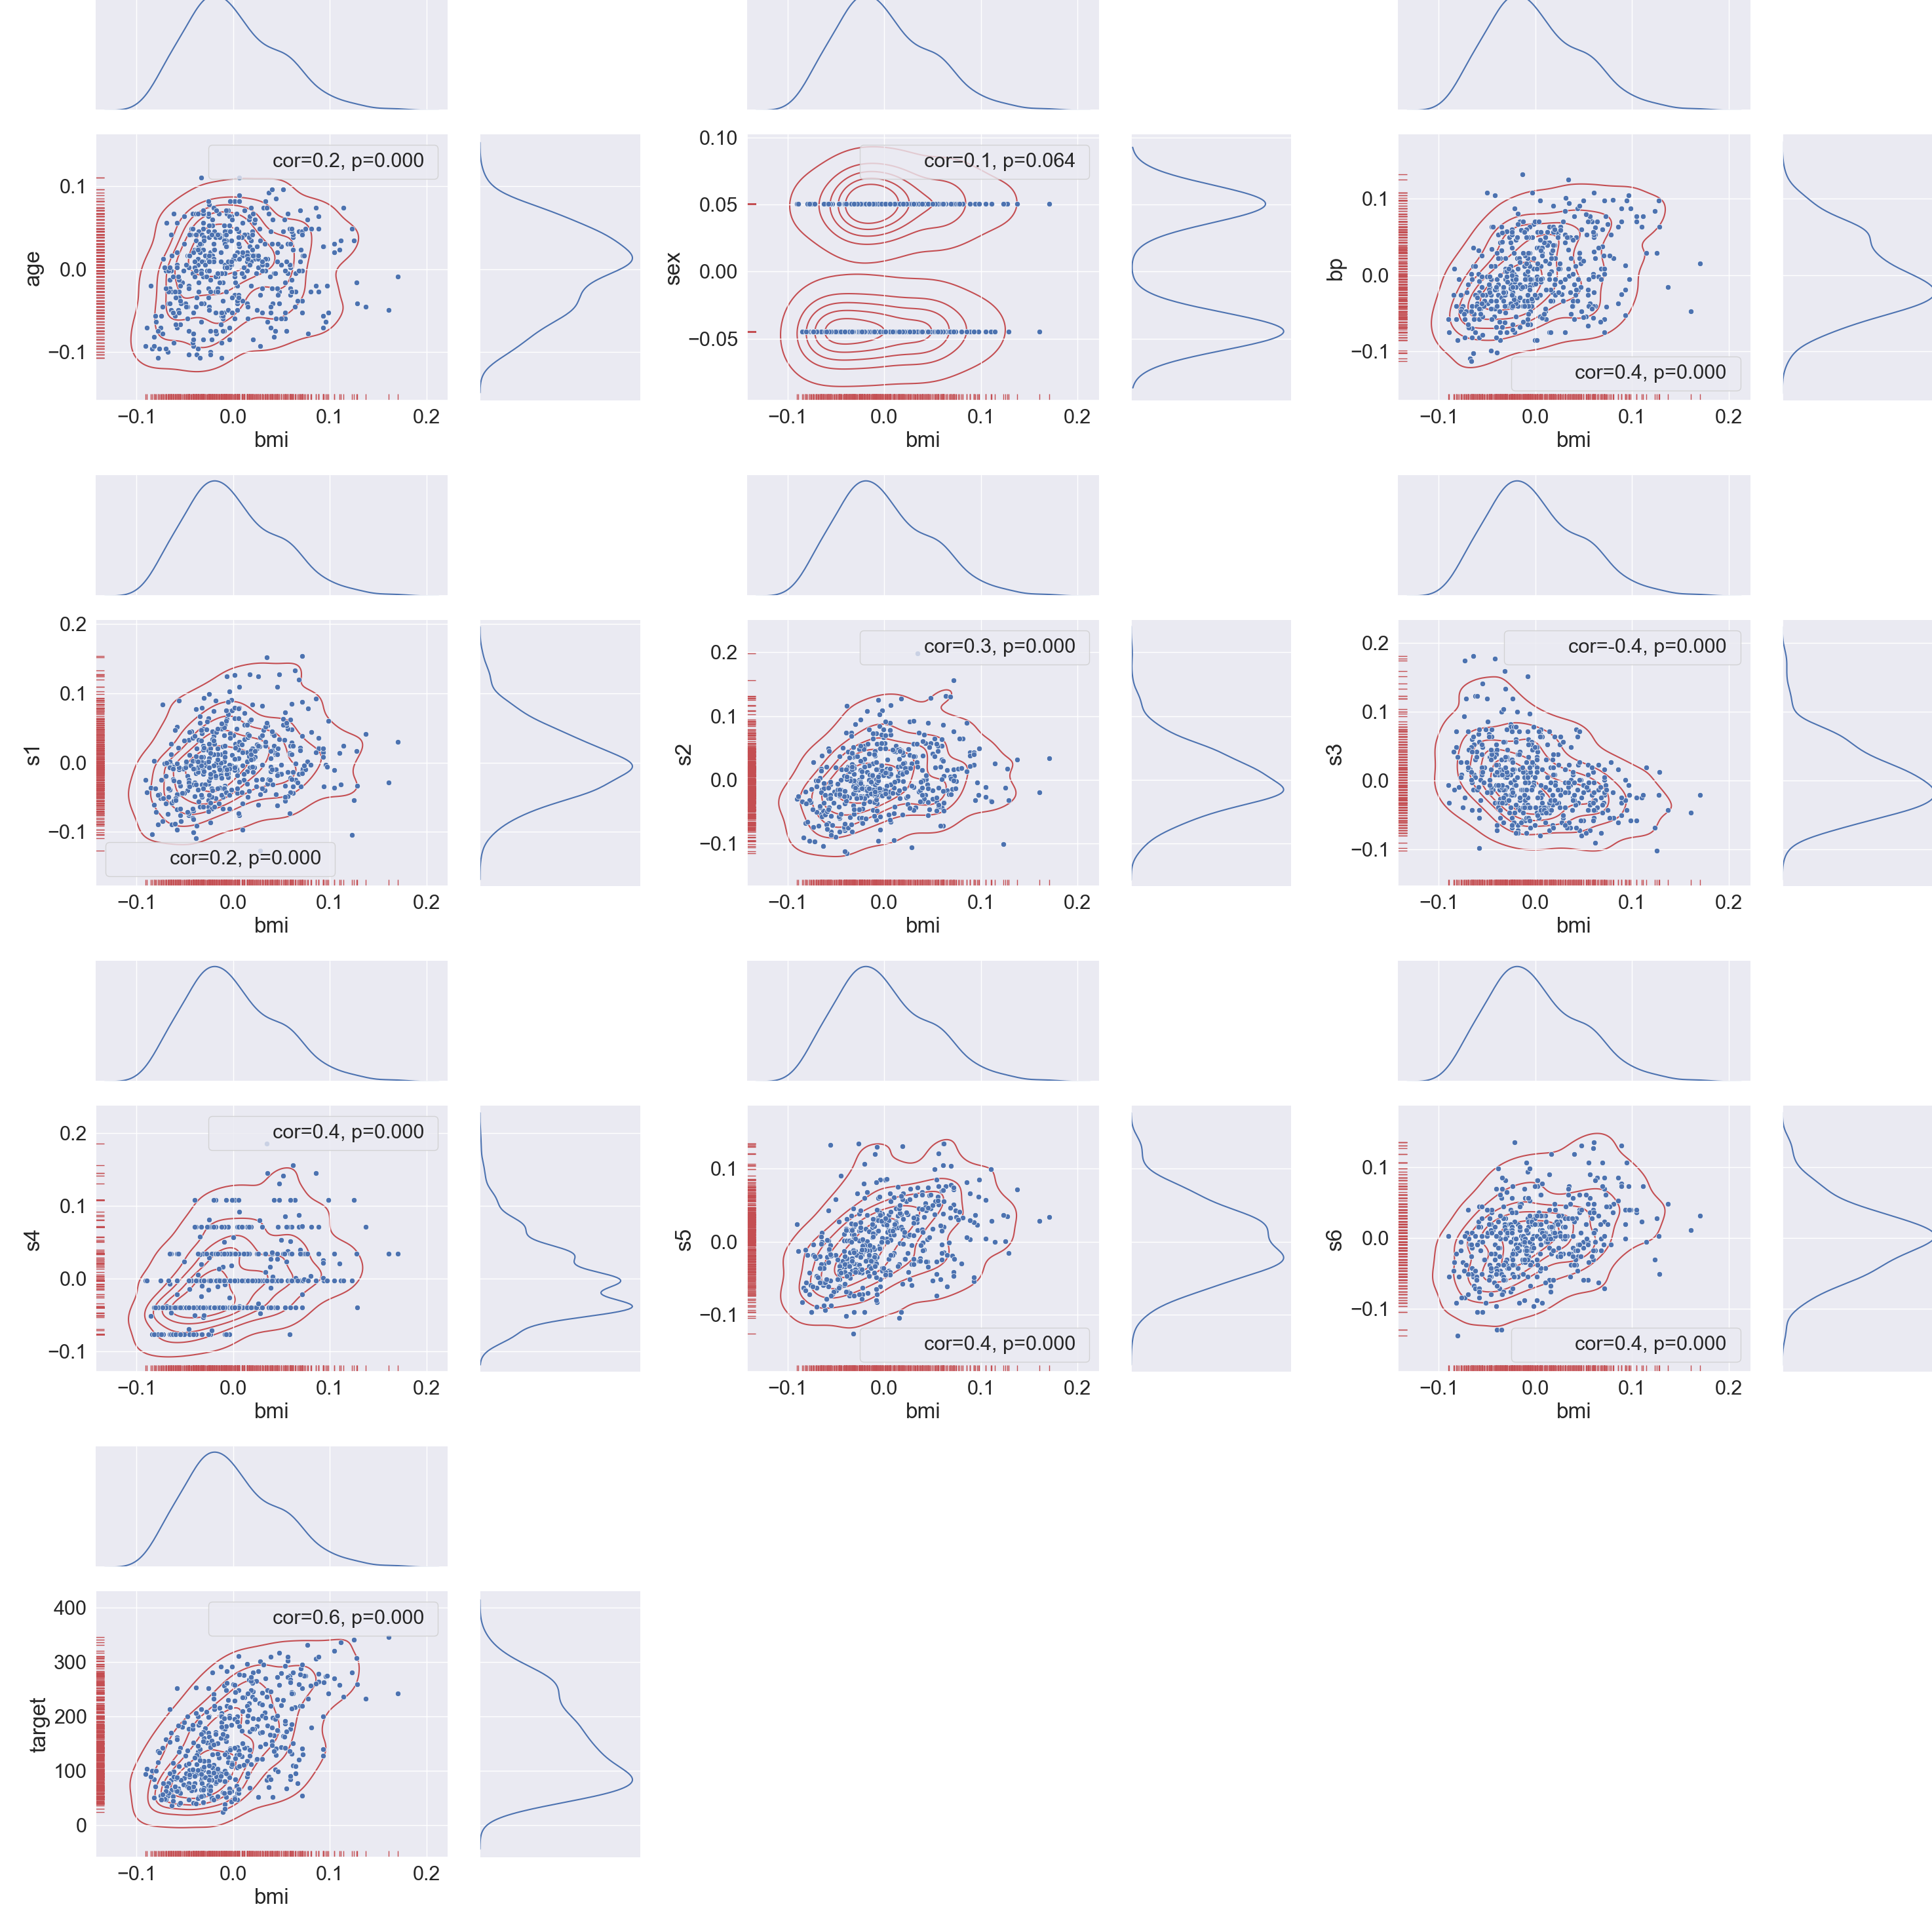

In [28]:
one_feat_compare_plot( data = df  ,
                    feat_name = "bmi",
                    n_feat  = 10 , 
                    n_subp = 3 , 
                    font_scale = 2 ,
                    x_size = 30 , 
                    y_size = 30 )

 
We can find a positive Pearson correlation between *BMI* with *target , s5 , s6 , s2* and *bp* . What changes between those relations is correlation level and the standard deviation magnitude that indicates that other fenomenas are involved.

Curious is the s4  sample data graphic shape that look like line distributed

*BMI* and *SEX* on the other side ar not correlated.

P-values are almost under the 0.05 or 5% threshold that means that data distributions are far from random and therefore of a good significance.



2.2 S1
---

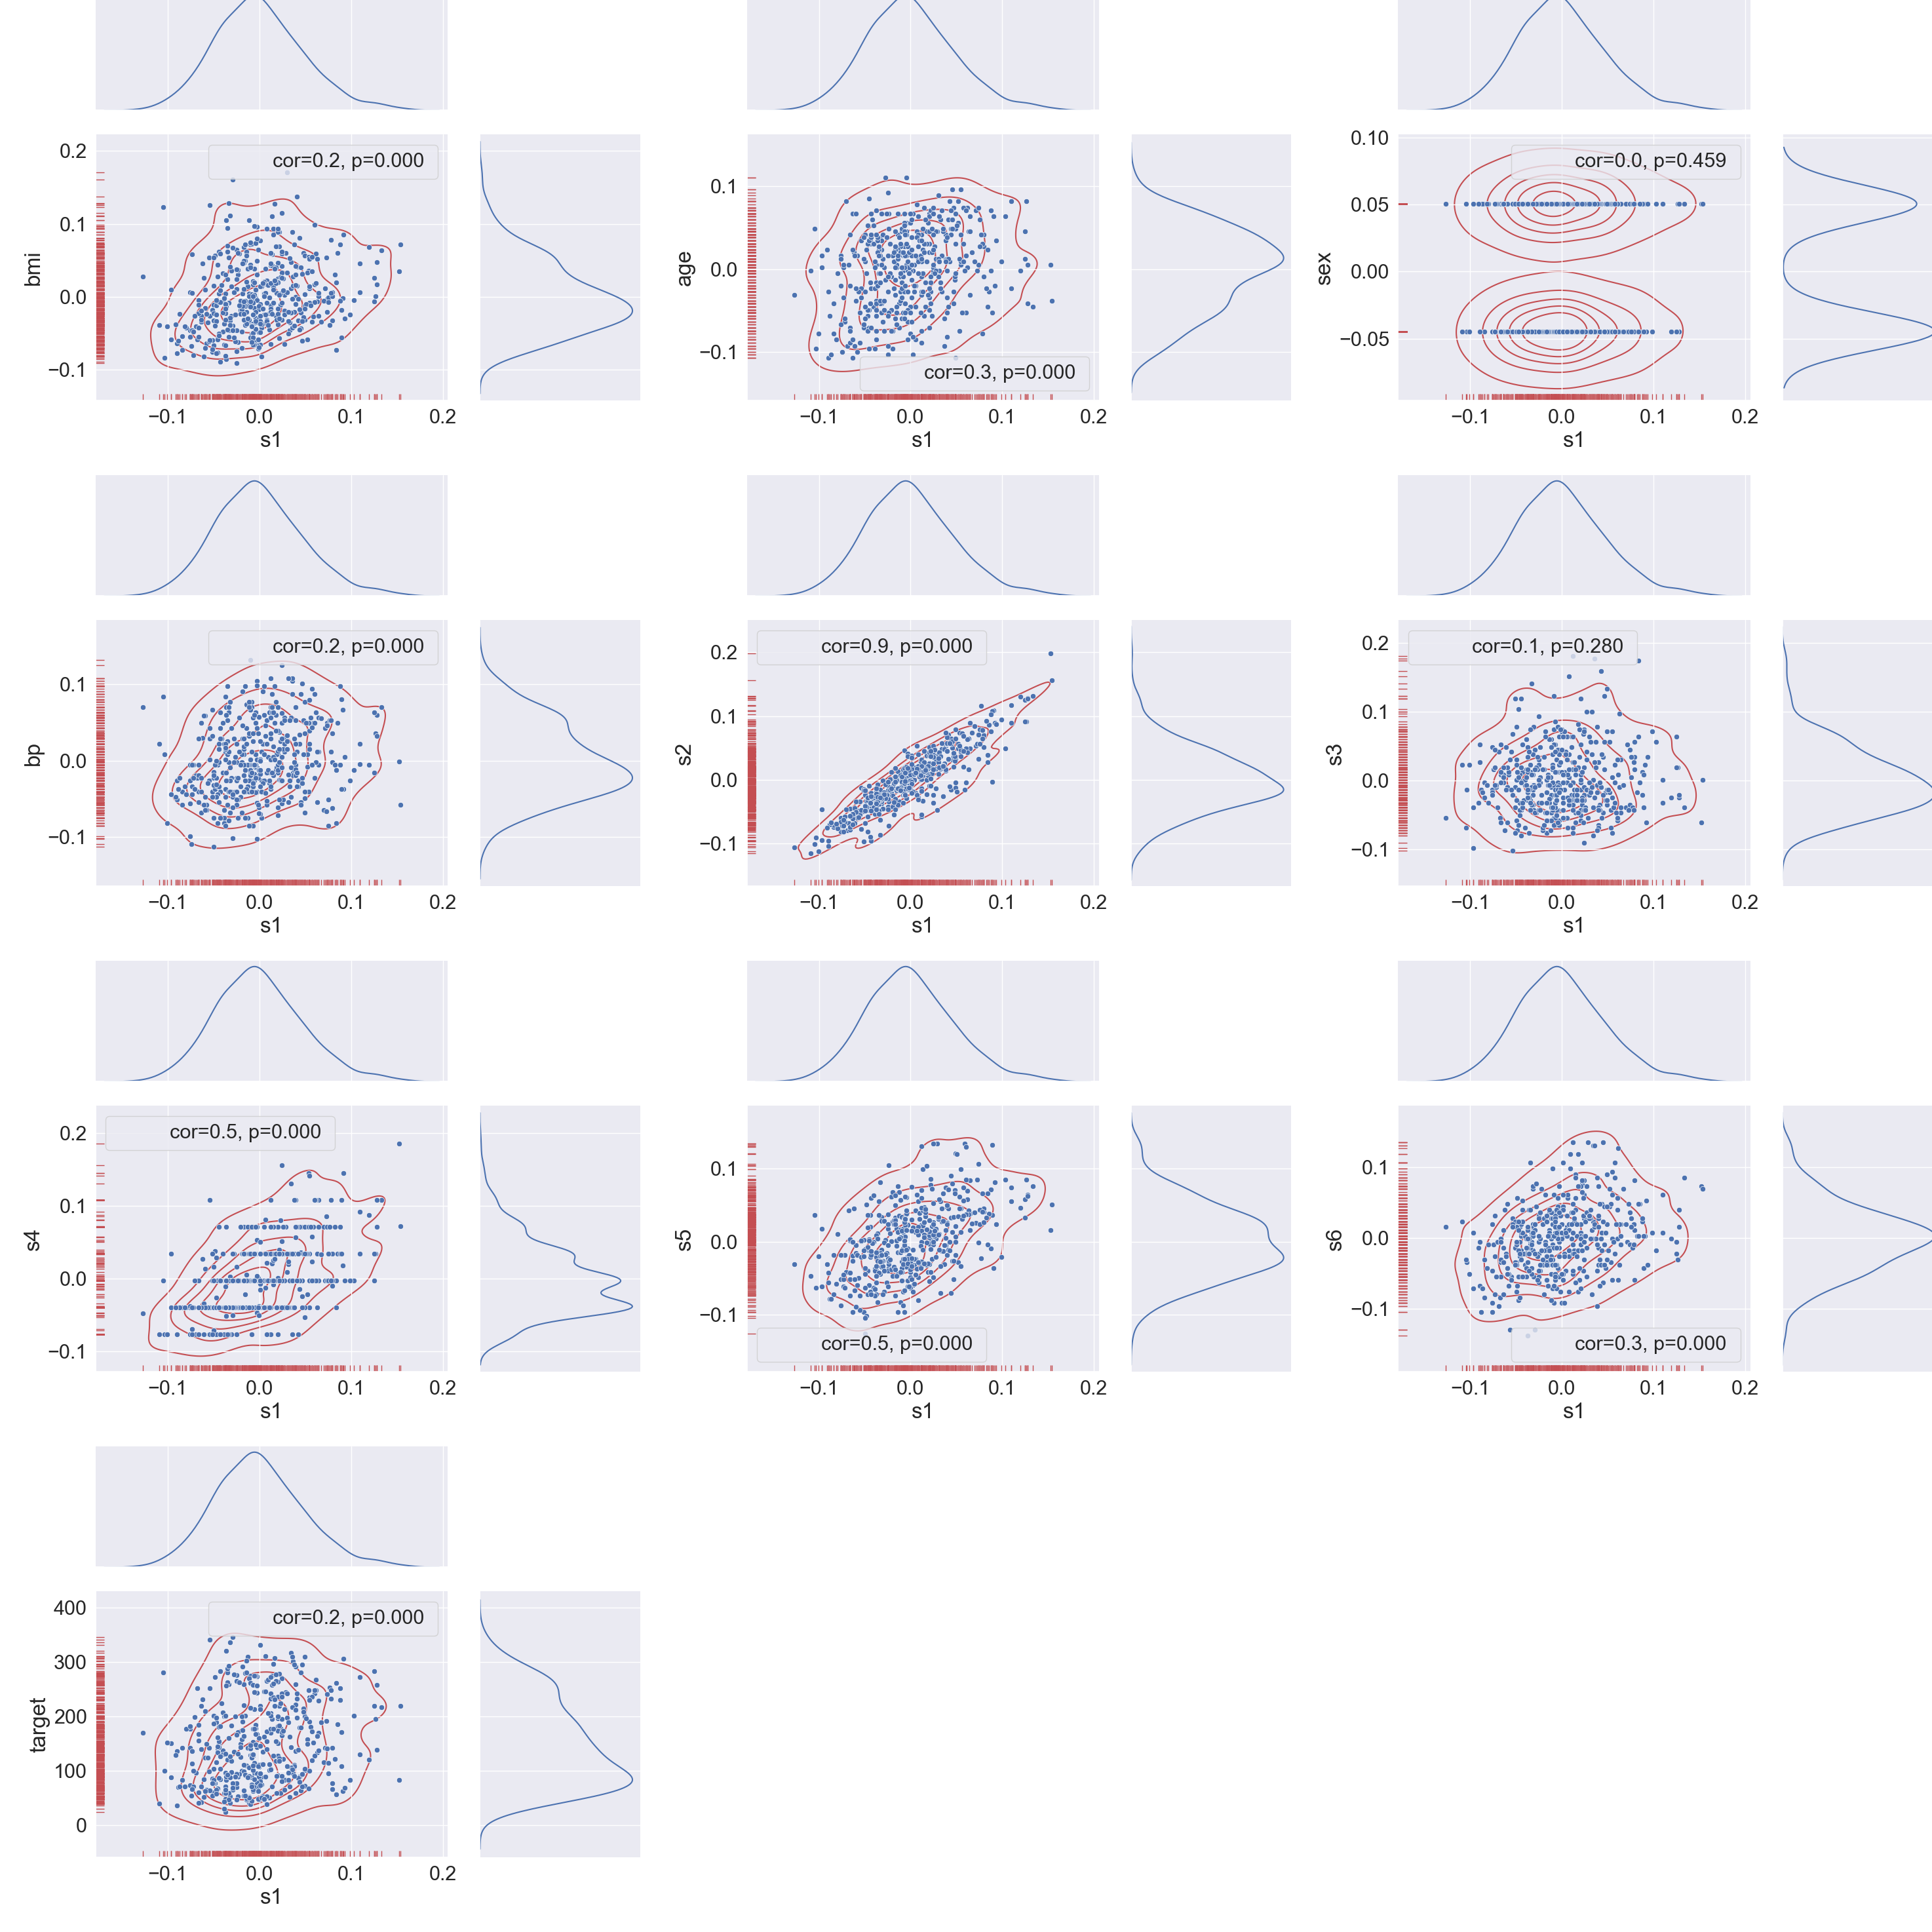

In [29]:
one_feat_compare_plot( data = df  ,
                    feat_name = "s1",
                    n_feat  = 10 , 
                    n_subp = 3 , 
                    font_scale = 2 ,
                    x_size = 30 , 
                    y_size = 30 )

On the graphs above we can see that:
<ul>
        <li><i>s1</i> and <i>s2</i> are strongly correlated. It seems useful to delete feature <i>s2</i> because is less correlated to other features wheras <i>s1</i> is more connected. </li>
        <li> again <i>s4</i> is showing a stratified distribution and shifts in relation with <i>s1</i></li>
        <li> <i>s1 - target</i> and <i>s1 - s3</i> are almost uncorrelated and p-values are very far from significance.</li>
</ul>

2.3 S2
--- 

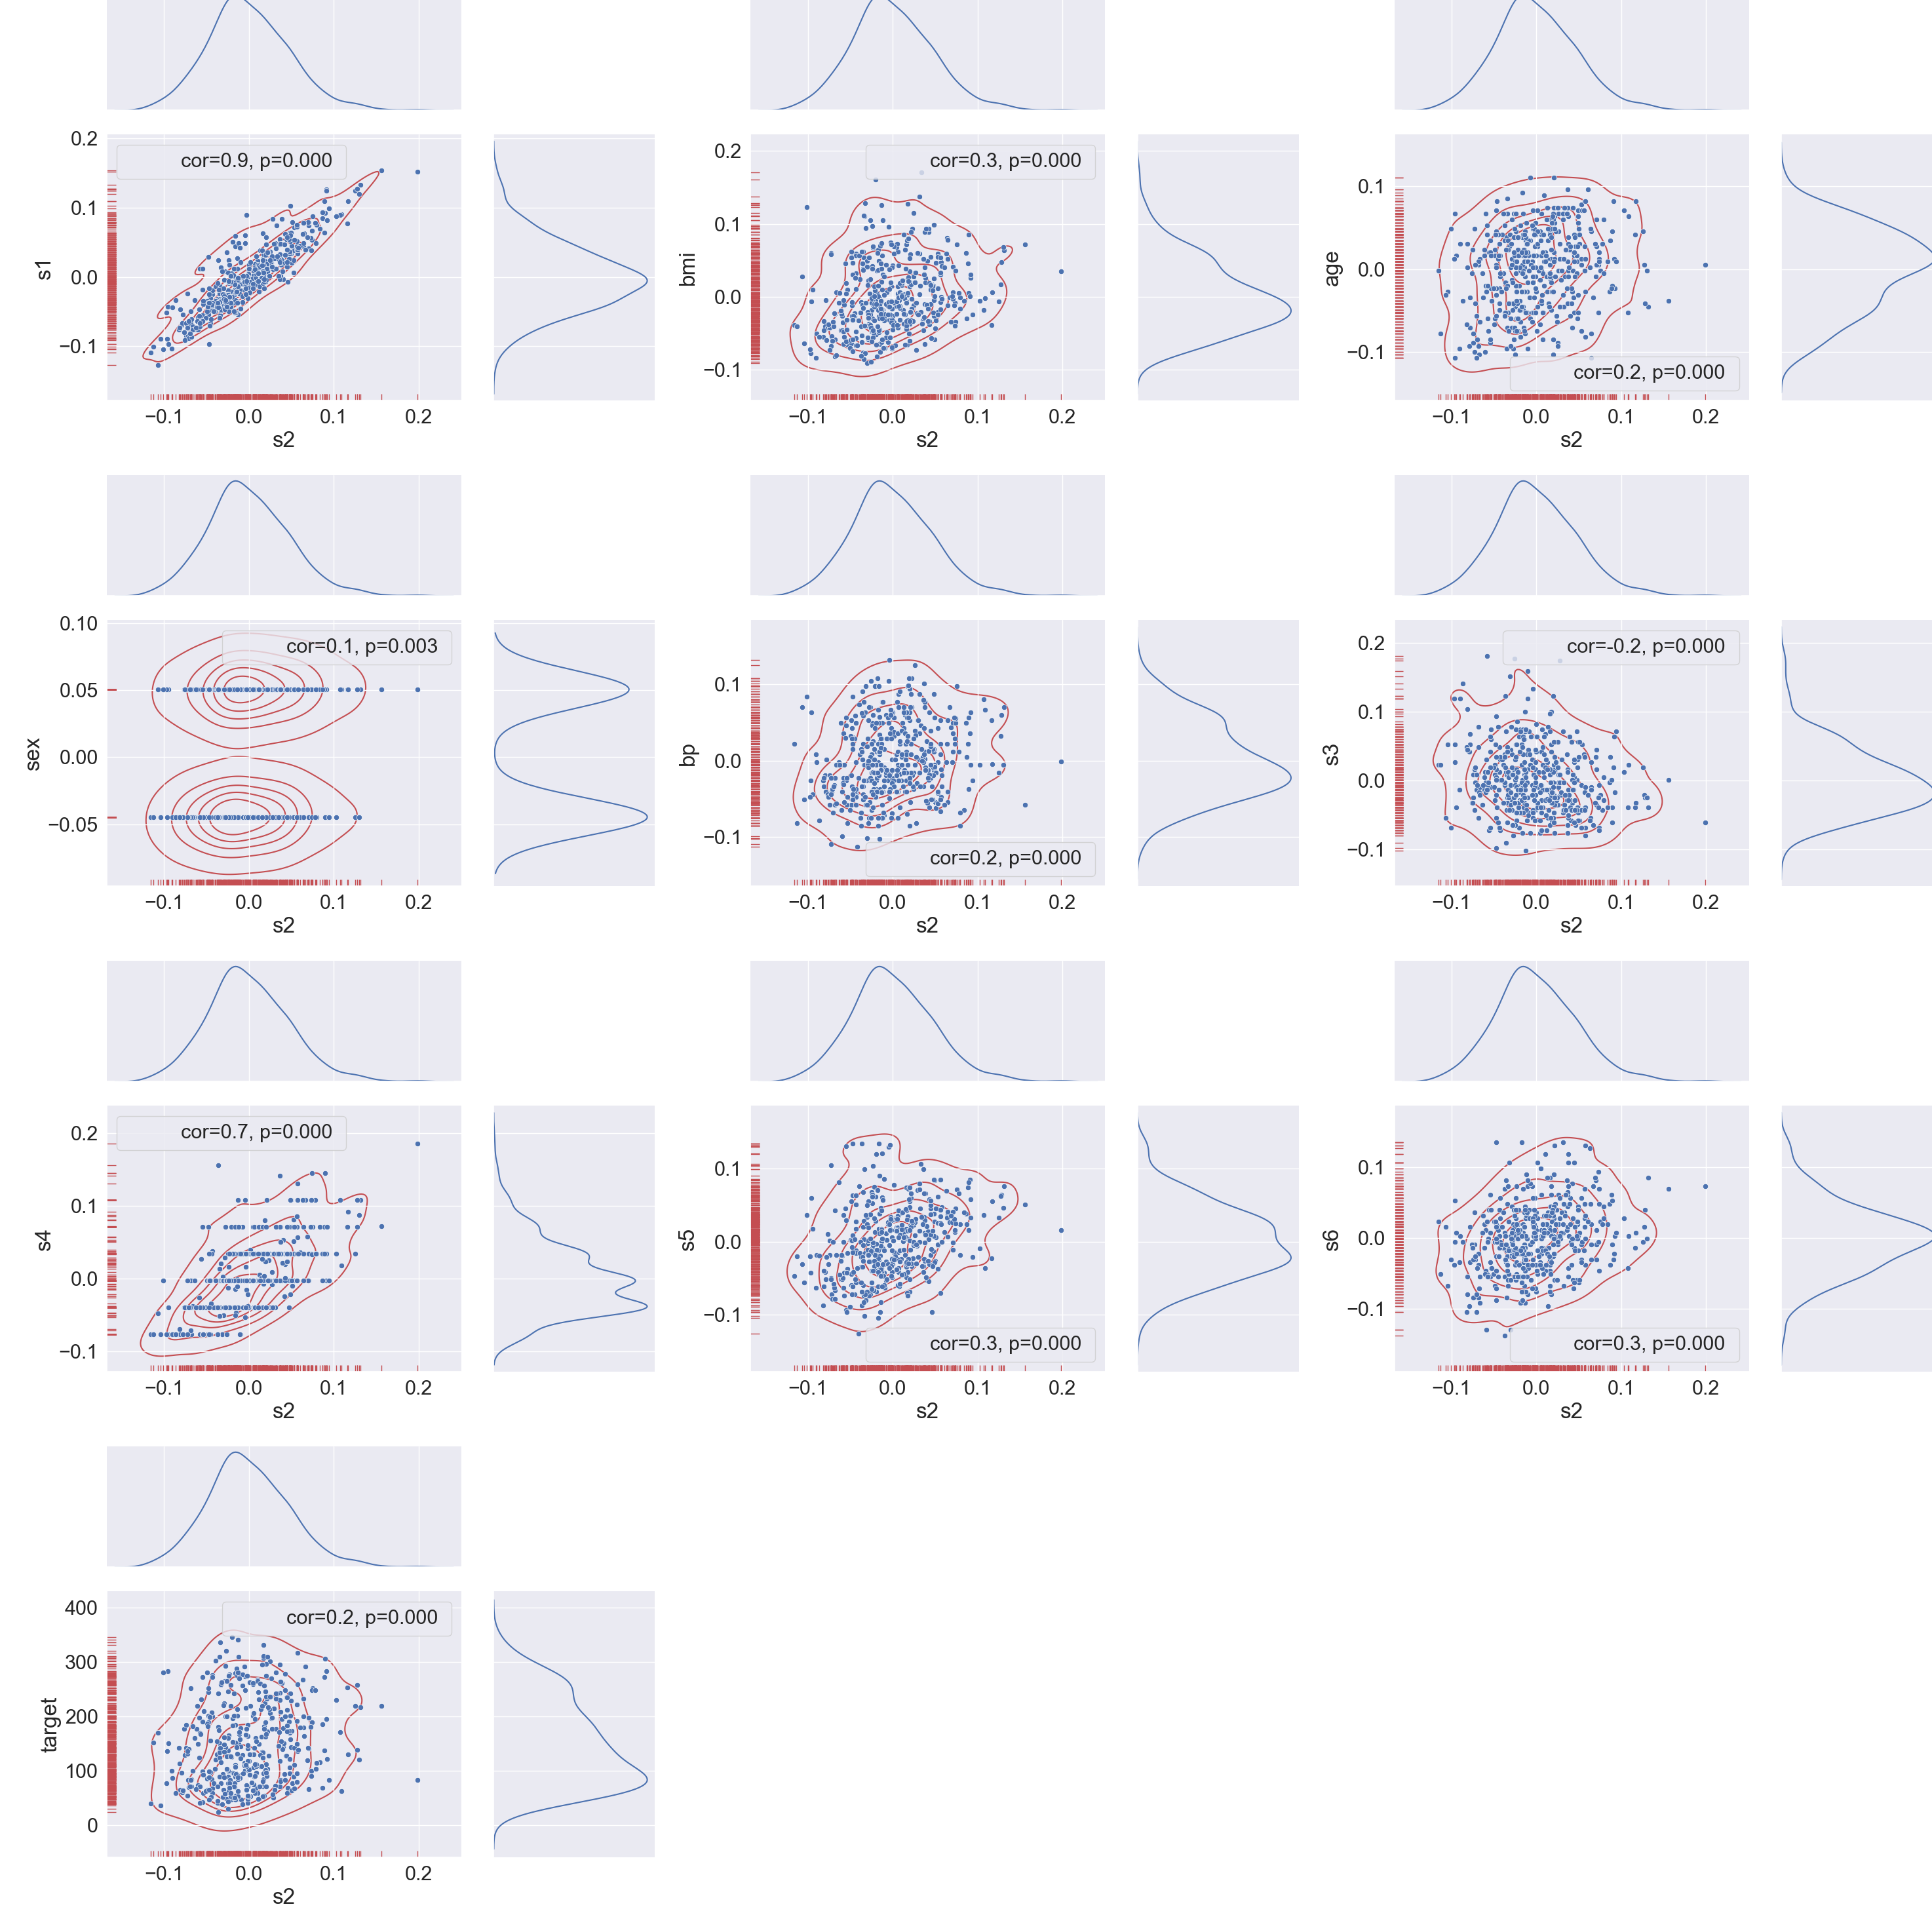

In [30]:
one_feat_compare_plot( data = df  ,
                    feat_name = "s2",
                    n_feat  = 10 , 
                    n_subp = 3 , 
                    font_scale = 2 ,
                    x_size = 30 , 
                    y_size = 30 )

Comparing *s1* and *s2* pairs ditributions we can say that the discrepancy between the two features is really tiny.

2.4 S3
--- 

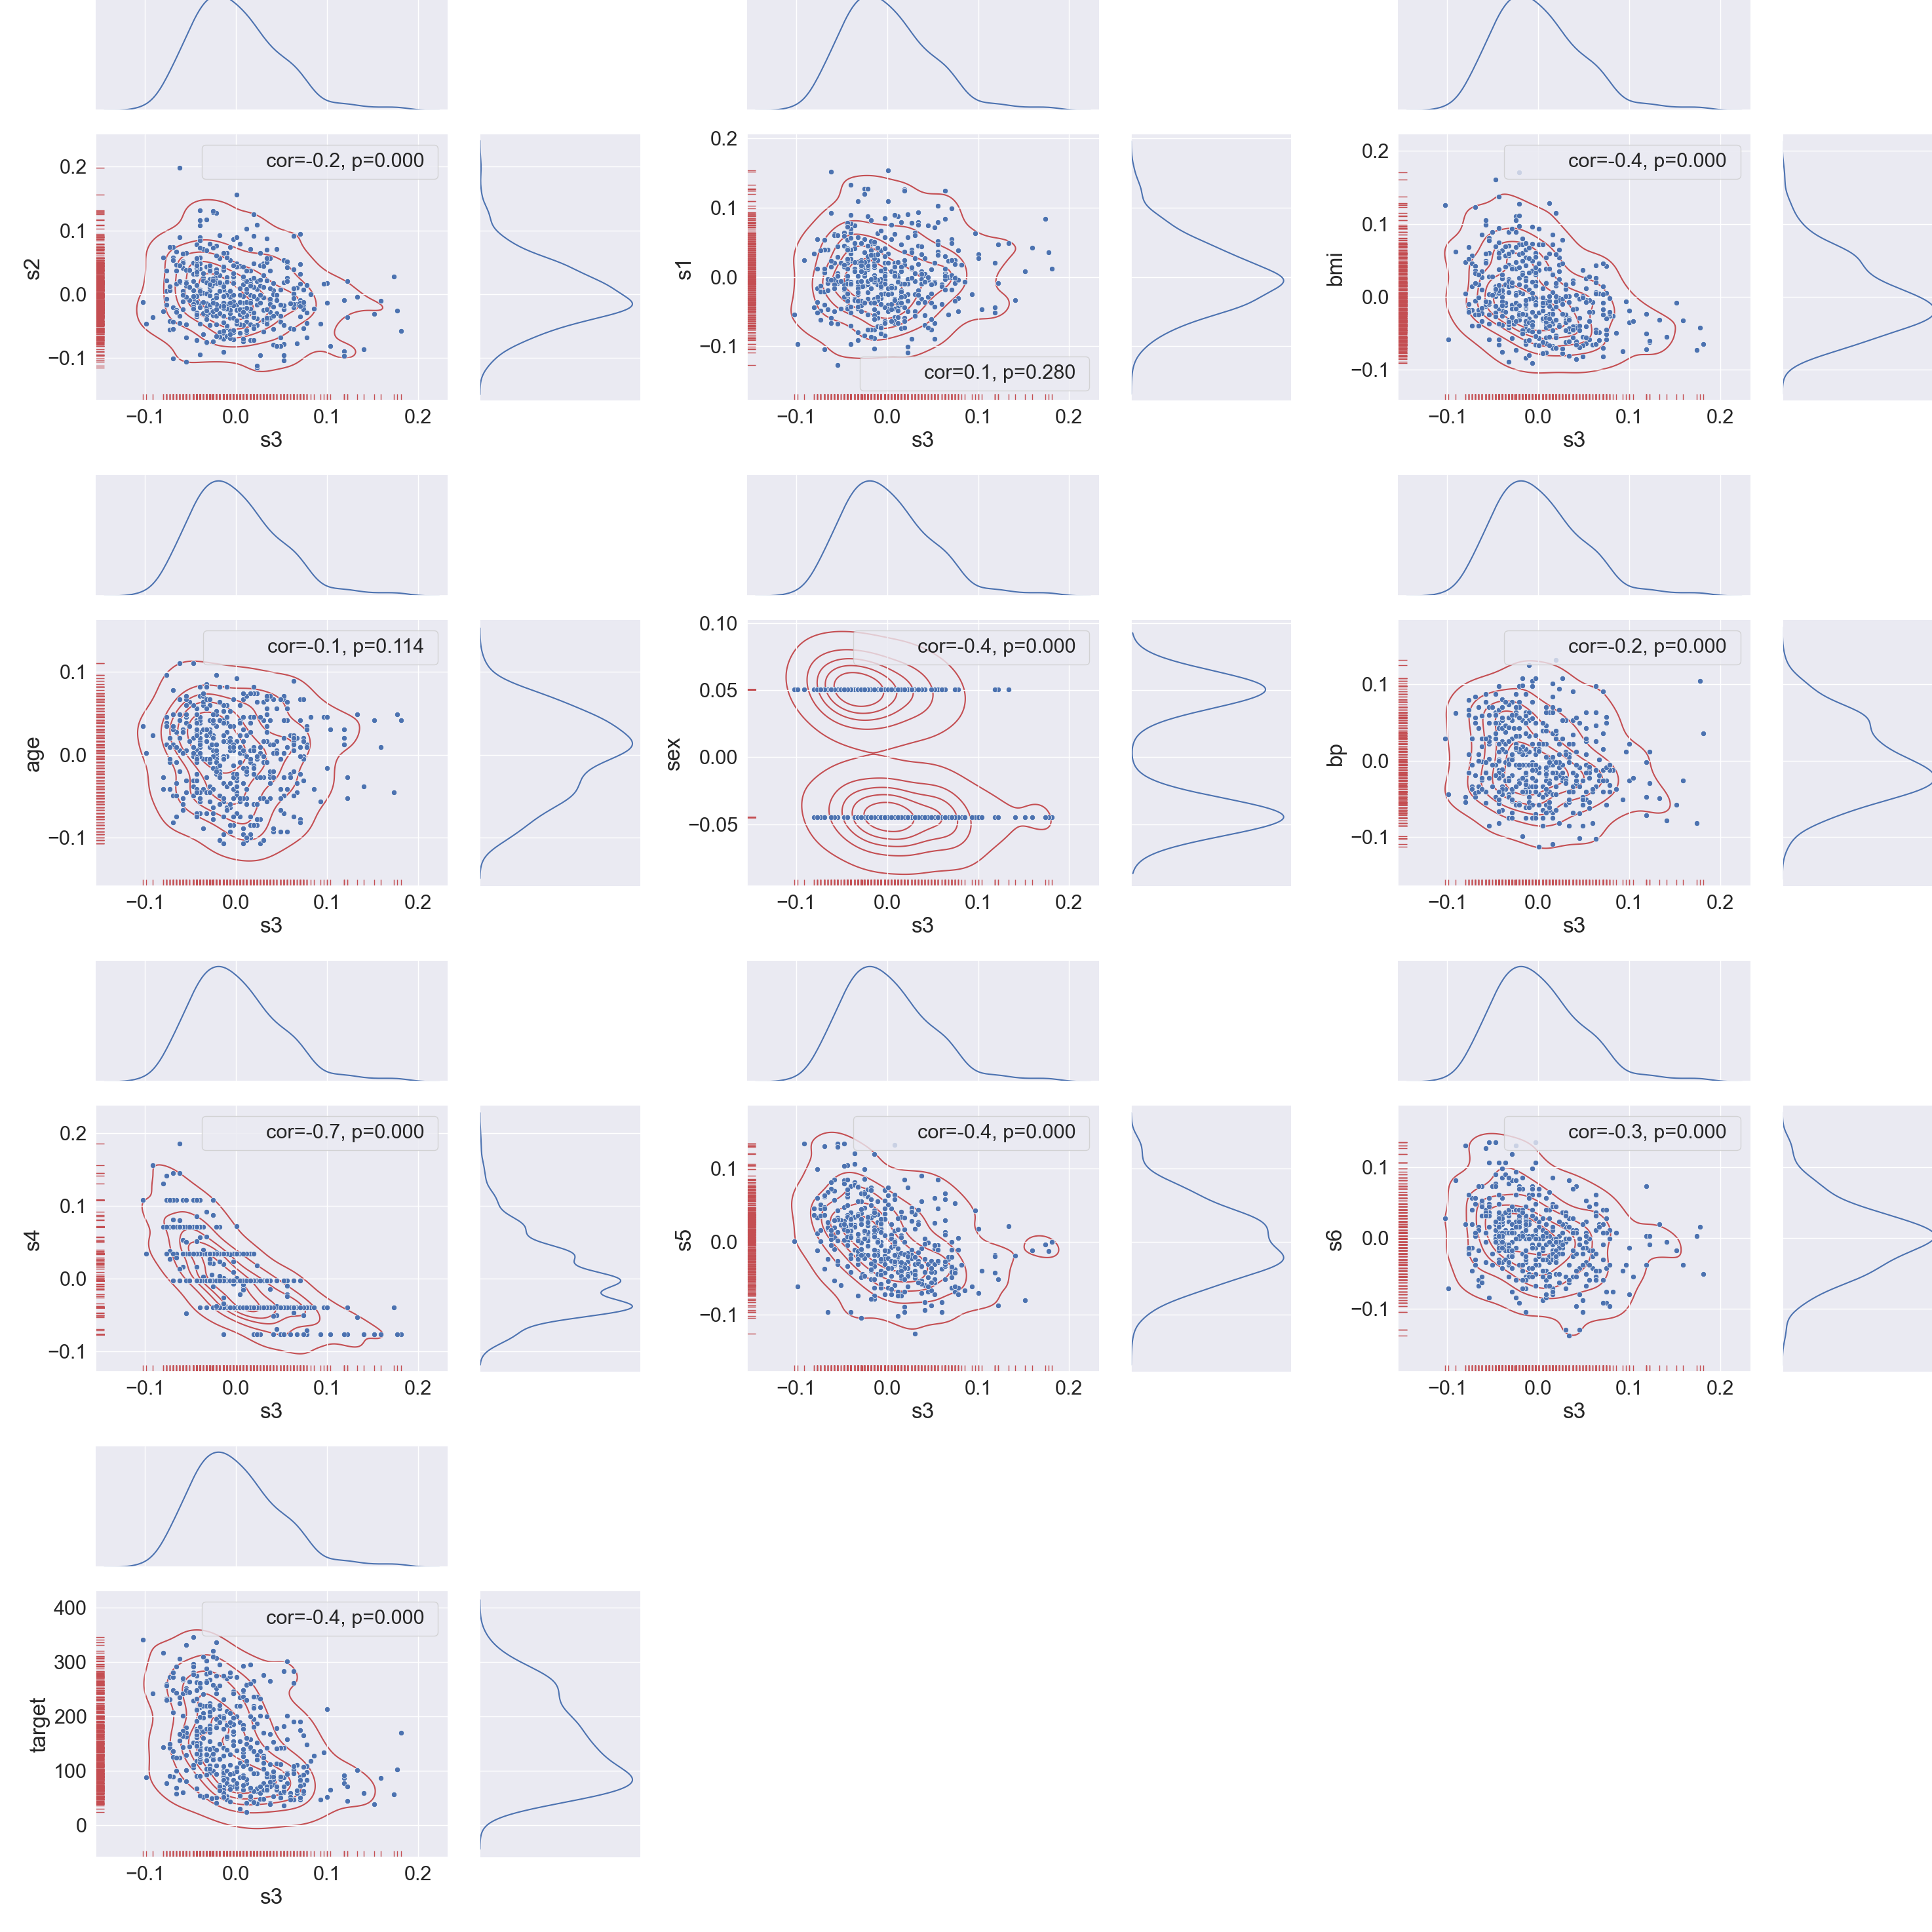

In [31]:
one_feat_compare_plot( data = df  ,
                    feat_name = "s3",
                    n_feat  = 10 , 
                    n_subp = 3 , 
                    font_scale = 2 ,
                    x_size = 30 , 
                    y_size = 30 )

Here we will focus on graph <i>s3 - s4</i> to see that even if the second feature is stratified, is strongly correlated to the first. It can be reasonable to transform s4 in a categorical variable assigning a value for every range. In this way the algorithm will be simplified and may be the optimization can achieve better results.

<AxesSubplot:>

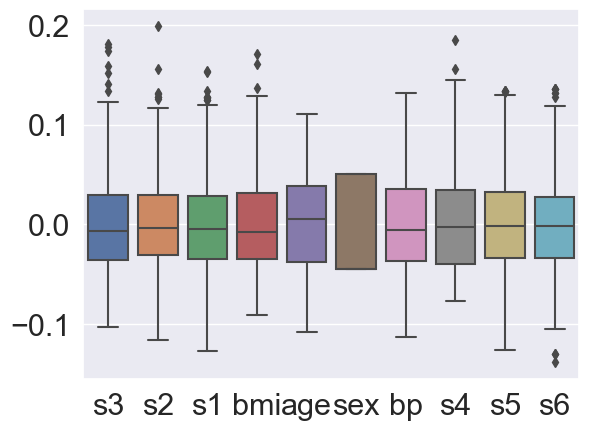

In [32]:
sns.boxplot(data=df.iloc[:,:-1])

Here we can have a general view of the outliers distribution for every feature. *bmi , s1 , s2 , s3* and *s4* have datapoints falling above the Q1-1.5* IQR and Q3+1.5* IQR percentile. It can be useful to analyze them further.

3.Features Transformation
---

In this section we will try to simplify the s4 feature meaning that because of its "stratified" distribution it can be categorized in more discrete values. 

In [33]:
df_s4 = df["s4"].value_counts().to_frame()
df_s4 = df_s4.reset_index()
df_s4 = df_s4.sort_values(by=["index"])
df_s4 = df_s4.rename(columns={"index":"s4_values", "s4":"s4_counts"})
df_s4 = df_s4.reset_index(drop = True)


<AxesSubplot:xlabel='s4_values', ylabel='s4_counts'>

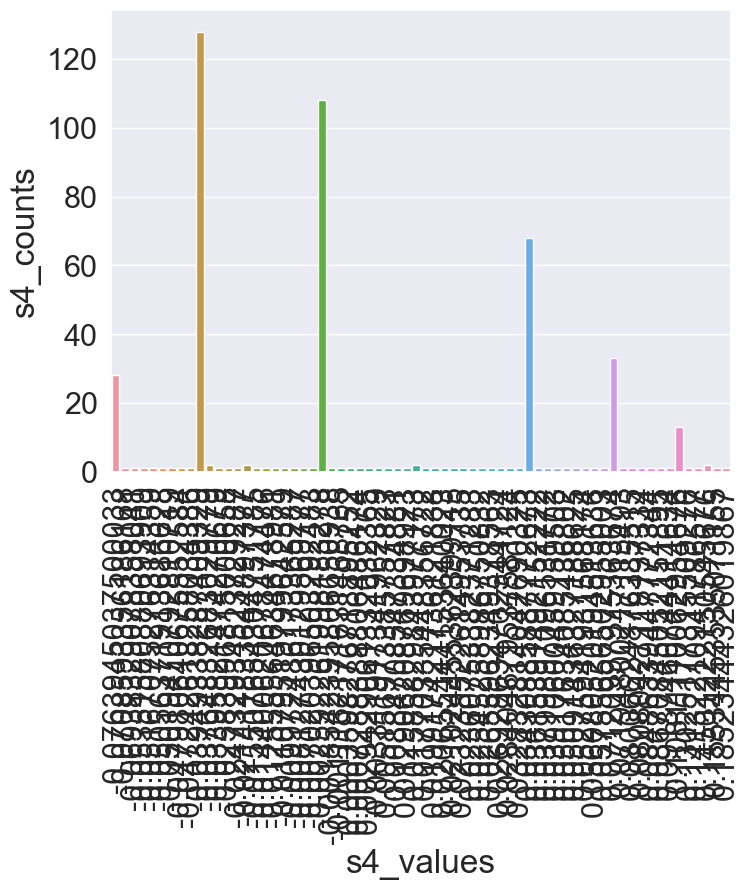

In [34]:
dimensions = (8, 6)
fig, ax = plt.subplots(figsize=dimensions)
plt.xticks(rotation=90)
sns.barplot(ax = ax, data=df_s4, x="s4_values" , y= "s4_counts")

Here we can see that there are few values much more frequent then other spurious values. What I want to do is simplify this feature grouping spurious in between data with a unique value.
Therefore I will transform continuous data in more simplified discrete ordinal data.

In [35]:
df_s4_best_freq = df_s4.loc[df_s4["s4_counts"] > 3,:]
df_1 = df.copy()
df_1["s4_round"] = df_1.s4.round(decimals = 5)
df_s4_best_freq.reset_index(drop=True, inplace=True)
df_cat = pd.DataFrame(np.arange(1 , len(df_s4_best_freq) + 1), columns = ["s4_cat"])
df_s4_best_freq["s4_round"] = df_s4_best_freq.s4_values.round(decimals = 5)
df_s4_2 = pd.concat([df_s4_best_freq,df_cat], axis = 1 , ignore_index = False) 

In [36]:
df_s4_2

s4_values  s4_counts  s4_round  s4_cat
0  -0.076395         28  -0.07639       1
1  -0.039493        128  -0.03949       2
2  -0.002592        108  -0.00259       3
3   0.034309         68   0.03431       4
4   0.071210         33   0.07121       5
5   0.108111         13   0.10811       6

In [37]:
df_1.head()

s3        s2        s1       bmi       age       sex        bp  \
0 -0.043401 -0.034821 -0.044223  0.061696  0.038076  0.050680  0.021872   
1  0.074412 -0.019163 -0.008449 -0.051474 -0.001882 -0.044642 -0.026328   
2 -0.032356 -0.034194 -0.045599  0.044451  0.085299  0.050680 -0.005670   
3 -0.036038  0.024991  0.012191 -0.011595 -0.089063 -0.044642 -0.036656   
4  0.008142  0.015596  0.003935 -0.036385  0.005383 -0.044642  0.021872   

         s4        s5        s6  target  s4_round  
0 -0.002592  0.019907 -0.017646   151.0  -0.00259  
1 -0.039493 -0.068332 -0.092204    75.0  -0.03949  
2 -0.002592  0.002861 -0.025930   141.0  -0.00259  
3  0.034309  0.022688 -0.009362   206.0   0.03431  
4 -0.002592 -0.031988 -0.046641   135.0  -0.00259

In [38]:
df_1["s4_cat"] = 0.0
d_pos_deltas = {}
d_neg_deltas = {}
for i , value in enumerate(df_1["s4_round"]):
    if value not in df_s4_2.values:
        for v , category in zip(df_s4_2["s4_round"],df_s4_2["s4_cat"]):  
            if v > 0 and value > 0 : 
                d_pos_deltas.update({category : abs(v - value)}) 
            elif v < 0 and value < 0 : 
                d_neg_deltas.update({category : abs(v - value)}) 
        # Sorting in ascending order. The first delta is the lowest value.
        d_pos_deltas_sort = sorted(d_pos_deltas.items() , key = lambda x:x[1])
        d_neg_deltas_sort = sorted(d_neg_deltas.items() , key = lambda x:x[1])
        if value > 0 :
            if value < v :
                # Access key by index : key is the category
                idx_match = list(d_pos_deltas_sort)[0][0]
                df_1.loc[i , "s4_cat"] =  float(idx_match) - 0.5 
            else:
                idx_match = list(d_pos_deltas_sort)[0][0]
                df_1.loc[i , "s4_cat"] =  float(idx_match) + 0.5 
        else:
            if value < v :
                # Access key by index : key is the category
                idx_match = list(d_neg_deltas_sort)[0][0]
                df_1.loc[i , "s4_cat"] =  float(idx_match) - 0.5 
            else:
                idx_match = list(d_neg_deltas_sort)[0][0]
                df_1.loc[i , "s4_cat"] =  float(idx_match) + 0.5                 
    else:
        idx_match = df_s4_2.loc[df_s4_2["s4_round"] == value, "s4_cat"]
        idx_match = int(idx_match)
        value_match = df_s4_2.loc[df_s4_2["s4_round"] == value, "s4_round"] 
        value_match = float(value_match)
        if (not pd.isna(idx_match )) and (not pd.isna(value_match )):
            if value  == value_match:
                df_1.at[i , "s4_cat"] =  float(idx_match)
np_s4 = df_1["s4_cat"].to_numpy().reshape(-1, 1)
# Here I'm using MinMaxScaler because s4 data are not distributed like a Gaussian distribution. 
# Moreover using StandardScaler data samples values will not range between 0 and 1 with respect to the other features and the model will not fit properly.
df_1["s4_std_scaled"] = MinMaxScaler().fit_transform(np_s4)                   
 


In [39]:
df_1["s4_std_scaled"].head()

0    0.416667
1    0.250000
2    0.416667
3    0.583333
4    0.416667
Name: s4_std_scaled, dtype: float64

<AxesSubplot:xlabel='s4_std_scaled', ylabel='s4_std_scaled_counts'>

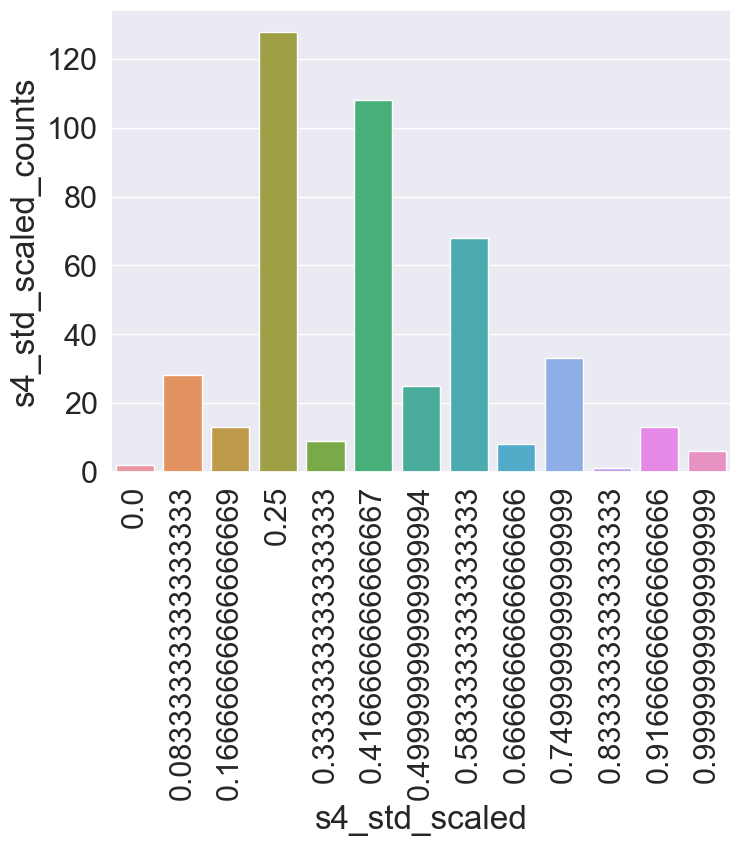

In [40]:
df_s4_1 = df_1["s4_std_scaled"].value_counts().to_frame()
df_s4_1 = df_s4_1.reset_index()
df_s4_1 = df_s4_1.sort_values(by=["index"])
df_s4_1 = df_s4_1.rename(columns={"index":"s4_std_scaled", "s4_std_scaled":"s4_std_scaled_counts"})
df_s4_1 = df_s4_1.reset_index(drop = True)
fig1, ax1 = plt.subplots(figsize=dimensions)
plt.xticks(rotation=90)
sns.barplot(ax = ax1, data=df_s4_1, x="s4_std_scaled" , y= "s4_std_scaled_counts")

Here we can see that we have discretized the data and may be this will improve the model performance.

In [41]:
df_2 = df_1.copy()
cols = ["s4_round","s4_cat","s4"]
df_2.drop(columns = cols , axis = 1 , inplace = True)
sr_feat_to_compare = df_2.pop("s4_std_scaled")
df_2.insert(0 , "s4_std_scaled" , sr_feat_to_compare )

4.Outliers
===

Here the scope is to find outliers in the data with two different methods:
    <ul>
        <li> Quantile method </li>
        <li> Mahalanobis distance and Chi-squared </li>
    </ul>

4.1 Quantile method
---


In [42]:
def drop_outliers(df):
    l_s_outliers = []
    for col in df.columns:
        Q1 = df.loc[:,col].quantile(.25)
        Q3 = df.loc[:,col].quantile(.99)
        IQR = Q3-Q1
        l_s_outliers.append(df.loc[(df[col] <= (Q1-(1.5*IQR))) & (df[col] >= (Q3+(1.5*IQR))) , col ])
    return l_s_outliers 
l_s_outliers = drop_outliers(df_2) 


No outlier are removed with this tecnique.

In [43]:
l_s_outliers

[Series([], Name: s4_std_scaled, dtype: float64),
 Series([], Name: s3, dtype: float64),
 Series([], Name: s2, dtype: float64),
 Series([], Name: s1, dtype: float64),
 Series([], Name: bmi, dtype: float64),
 Series([], Name: age, dtype: float64),
 Series([], Name: sex, dtype: float64),
 Series([], Name: bp, dtype: float64),
 Series([], Name: s5, dtype: float64),
 Series([], Name: s6, dtype: float64),
 Series([], Name: target, dtype: float64)]

4.2 Mahalanobis distance and chi squared method
---

Mahalanobis distance is a very powerful metric because: 
    <ul>
        <li> it allows us to calculate the distance from the center of a sample point depending on the feature distribution. On the other hand Euclidean distance calculate distance from the point with same metric.</li>
        <li> we can set a boundary via Chi squared and find outliers </li>
        <li> results are not influenced by the scale like it is with Euclidean distance approach</li>
    </ul>

In [44]:
np_data = df_2.iloc[:,:-1].to_numpy()
# Covariance matrix
cov  = np.cov(np_data , rowvar=False)
# Covariance matrix power of -1
cov_pm1 = np.linalg.matrix_power(cov, -1)
# Center point
center = np.mean(np_data , axis=0)
# Distances between center point and 
dists = []
for i, val in enumerate(np_data):
      p1 = val
      p2 = center
      #mahalnobis distance formula D^2 = (x - x̄)^T * C^-1 * (x - x̄)
      dist = (p1-p2).T.dot(cov_pm1).dot(p1-p2)
      dists.append(dist)
np_dists = np.array(dists)
# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
#PPF is an inverse cumulative distribution function that gives the value associated witha specific cumulative probability
cutoff = chi2.ppf(0.975, np_data.shape[1])
# Index of outliers
outlier_idx = np.where(np_dists > cutoff )
np_outlier_idx = np.array(outlier_idx)
# Convert dimensionality from [n,m] ro [m , ]
outlier_idx_flat = np_outlier_idx.flatten()
# Drop rows containing outliers
df_dropped_outliers = df_2.drop(index = outlier_idx_flat , axis=0)
df_dropped_outliers.reset_index(drop=True, inplace=True)

In [45]:
outlier_idx_flat

array([ 11,  15,  23,  32,  35,  58, 110, 123, 141, 169, 230, 254, 256,
       260, 261, 286, 321, 322, 323, 352, 353, 371, 382, 394, 405, 441],
      dtype=int64)

5.Hyperparameter Tuning
===

Different training set are used to check where the features transformation benefits the metrics scores

In [46]:
X_train, X_test ,y_train, y_test = train_test_split(df_2.iloc[:,:-1],df_2.iloc[:,-1],test_size=0.1,random_state=42) 
X_train_filtered = X_train.drop(columns = "s2", inplace = False)
X_test_filtered = X_test.drop(columns = "s2", inplace = False)

In [47]:
X_train_do, X_test_do ,y_train_do, y_test_do = train_test_split(df_dropped_outliers.iloc[:,:-1],df_dropped_outliers.iloc[:,-1],test_size=0.1,random_state=42) 
X_train_filtered_do = X_train_do.drop(columns = "s2", inplace = False)
X_test_filtered_do = X_test_do.drop(columns = "s2", inplace = False)
X_train_filtered_do.reset_index(drop = True , inplace = True)
X_test_filtered_do.reset_index(drop = True , inplace = True)

In [48]:
X_test_filtered_do.head()


s4_std_scaled        s3        s1       bmi       age       sex        bp  \
0       0.916667 -0.039719  0.133274  0.063852 -0.045472  0.050680  0.070072   
1       0.500000 -0.013948 -0.001569  0.064930 -0.005515 -0.044642  0.035644   
2       0.416667 -0.017629 -0.016704 -0.023451 -0.012780 -0.044642 -0.040099   
3       0.416667  0.030232  0.060349  0.017506  0.016281 -0.044642 -0.022885   
4       0.166667 -0.054446 -0.126781  0.028284 -0.030942  0.050680  0.070072   

         s5        s6  
0  0.075741  0.085907  
1 -0.018114  0.032059  
2 -0.038460 -0.038357  
3  0.037236 -0.001078  
4 -0.030748  0.015491

To choose SVR hyperparameters we will follow these rules:
<ul>
    <li> C : is a regularization term therefore we can choose value from -10^3 to 10^3</li>
    <li> gamma : is related to the inverse of variance of RBF kernel therefore we will use the same logic we used for C parameter. </li>
    <li> epsilon : is the measure of the error that we don't care about. Therefore the value is related to target value. We will choose again values from 10^-2 to 10^2 </li>
</ul>

5.1 Random Search Cross Validation
---

In [49]:
SVR_hgrid_1 = [
              {'kernel':['linear'],
               'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
               'epsilon':[ 1e-2, 1e-1, 1e0, 1e1, 1e2]},
              
              {'kernel':['poly'],
               'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
               'epsilon':[ 1e-2, 1e-1, 1e0, 1e1, 1e2],
               'degree':[2,3,5]},
    
              {'kernel':['rbf'],
               'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
               'gamma':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
               'epsilon':[ 1e-2, 1e-1, 1e0, 1e1, 1e2]},
  
             ]
svr = svm.SVR()
l_gs_res = []
l_gs = []
l_res = []
par = ["param_C", "param_gamma" , "param_epsilon", "mean_test_score" ,"mean_train_score" , "param_kernel"]
d_X = {0: ["all features" , X_train , X_test , y_train , y_test ] ,  
       1: ["dropped s2 feature" , X_train_filtered , X_test_filtered , y_train , y_test ] ,  
       2: ["all features without outliers" , X_train_do , X_test_do , y_train_do , y_test_do],  
       3: ["dropped s2 and outliers removed" , X_train_filtered_do , X_test_filtered_do , y_train_do , y_test_do]}  
d_score_res = {}
l_score_res = []
for k , dfs in  d_X.items() : 
        l_gs.append(RandomizedSearchCV(svr, 
                        param_distributions = SVR_hgrid_1,
                        n_iter=100, 
                        scoring='neg_mean_squared_error', 
                        verbose=0, 
                        n_jobs=1, 
                        refit = True, 
                        random_state = 42,
                        return_train_score=True))
        # Weights calculus
        l_gs[k].fit(dfs[1],dfs[3])
        # Pred calculus
        y_pred = l_gs[k].predict(dfs[2])
        # Metrics
        mse =  mean_squared_error(dfs[4], y_pred)
        rmse  = np.sqrt(mean_squared_error(dfs[4], y_pred))
        r2  = r2_score(dfs[4], y_pred)
        adj_r2 = 1 - ((1 - r2 ) * (len(dfs[1]) - 1)/
                (len(dfs[1]) - dfs[1].shape[1] - 1))
        df_res = pd.DataFrame(l_gs[k].cv_results_)
        l_res.append(df_res[par])
        l_score_res.append({'Data Type' : dfs[0] , "Best Par" : l_gs[k].best_params_ , "RMSE" : rmse , "AdjR2": adj_r2.round(decimals = 4)})
        
        print(f'Data Type: {dfs[0]}    Best Par : {l_gs[k].best_params_}   RMSE : {rmse}    R2 : {r2.round(decimals = 4)}    AdjR2 : {adj_r2.round(decimals = 4)} ')
        

Data Type: all features    Best Par : {'kernel': 'rbf', 'gamma': 1.0, 'epsilon': 0.1, 'C': 1000.0}   RMSE : 52.74123010350276    R2 : 0.5453    AdjR2 : 0.5335 
Data Type: dropped s2 feature    Best Par : {'kernel': 'rbf', 'gamma': 1.0, 'epsilon': 1.0, 'C': 1000.0}   RMSE : 52.77708289614769    R2 : 0.5446    AdjR2 : 0.534 
Data Type: all features without outliers    Best Par : {'kernel': 'rbf', 'gamma': 10.0, 'epsilon': 10.0, 'C': 100.0}   RMSE : 45.84702402170415    R2 : 0.6626    AdjR2 : 0.6533 
Data Type: dropped s2 and outliers removed    Best Par : {'kernel': 'rbf', 'gamma': 10.0, 'epsilon': 10.0, 'C': 100.0}   RMSE : 45.40361019793448    R2 : 0.6691    AdjR2 : 0.6609 


5.2 Grid Search Cross Validation
---

In [50]:
SVR_hgrid_2 = {'kernel':['rbf'],
               'C':[10 , 50 , 53 , 54 ,  55],
               'gamma':[8 , 9 , 10 , 11 , 12  ],
               'epsilon':[0.1 , 0.5 ,  1 , 5 , 10  ]}

svr = svm.SVR()
l_gs_res = []
l_gs = []
l_res = []
par = ["param_C", "param_gamma" , "param_epsilon", "mean_test_score" ,"mean_train_score" , "param_kernel"]
d_X = {0: ["all features" , X_train , X_test , y_train , y_test ] ,  
       1: ["dropped s2 feature" , X_train_filtered , X_test_filtered , y_train , y_test ] ,  
       2: ["all features without outliers" , X_train_do , X_test_do , y_train_do , y_test_do],  
       3: ["dropped s2 and outliers removed" , X_train_filtered_do , X_test_filtered_do , y_train_do , y_test_do]}  
d_score_res = {}
l_score_res = []
for k , dfs in  d_X.items() : 
        l_gs.append(GridSearchCV(svr, 
                        SVR_hgrid_2, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        verbose=0, 
                        n_jobs=1, 
                        refit = True,
                        return_train_score=True))
        # Weights calculus
        l_gs[k].fit(dfs[1],dfs[3])
        # Pred calculus
        y_pred = l_gs[k].predict(dfs[2])
        # Metrics
        mse =  mean_squared_error(dfs[4], y_pred)
        rmse  = np.sqrt(mean_squared_error(dfs[4], y_pred))
        r2  = r2_score(dfs[4], y_pred)
        adj_r2 = 1 - ((1 - r2 ) * (len(dfs[1]) - 1)/
                (len(dfs[1]) - dfs[1].shape[1] - 1))
        df_res = pd.DataFrame(l_gs[k].cv_results_)
        l_res.append(df_res[par])
        l_score_res.append({'Data Type' : dfs[0] , "Best Par" : l_gs[k].best_params_ , "RMSE" : rmse , "AdjR2": adj_r2.round(decimals = 4)})
        
        print(f'Data Type: {dfs[0]}    Best Par : {l_gs[k].best_params_}   RMSE : {rmse}    R2 : {r2.round(decimals = 4)}    AdjR2 : {adj_r2.round(decimals = 4)} ')
        
  

Data Type: all features    Best Par : {'C': 53, 'epsilon': 5, 'gamma': 10, 'kernel': 'rbf'}   RMSE : 49.15903025267315    R2 : 0.6049    AdjR2 : 0.5947 
Data Type: dropped s2 feature    Best Par : {'C': 55, 'epsilon': 5, 'gamma': 9, 'kernel': 'rbf'}   RMSE : 48.833117197777185    R2 : 0.6101    AdjR2 : 0.6011 
Data Type: all features without outliers    Best Par : {'C': 50, 'epsilon': 0.5, 'gamma': 12, 'kernel': 'rbf'}   RMSE : 46.09293486120855    R2 : 0.659    AdjR2 : 0.6496 
Data Type: dropped s2 and outliers removed    Best Par : {'C': 53, 'epsilon': 0.1, 'gamma': 9, 'kernel': 'rbf'}   RMSE : 46.19319763826974    R2 : 0.6575    AdjR2 : 0.649 


From the GridSearch algorithm we can conclude that the best parameters are : C = 50 , Epsilon = 0.1 , Gamma = 10 , Kernel = rbf

We can say that dropping the feature s2 and removing some sample labelled as outliers, has improved the a Adjusted R2 and RMSE. That's quite great.

5.1 Used Metrics
---


Le metrics that we take into consideration are:
<ul>
    <li> R^2 SCORE : R^2 = 1 - ∑(y - ŷ)^2 / ∑(y - ȳ)^2   it's a percentage measure of the proportion of indipendent variables (features) that explains the dipendent variable. However R^2 SCORE is not a complete measure because:
        <ul> 
            <li> you can have low R^2 SCORE for a good model </li>
            <li> you can have high R^2 SCORE for a model that doesn't fit the data </li>
            <li> you must take a look at the residuals plot : it could often happen that, meaning that residuals are always too low or too high with respect to the mean </li>
        </ul>
    Therefore a better measure is ADJUSTED R^2 SCORE that has few improvements:
        <ul> 
            <li> Adjusted R^2 = 1 – [(1-R^2)*(n-1)/(n-k-1)]   
                <ul> 
                    <li> k is the number of features</li> 
                    <li> n is the number of observations</li>
                </ul>
            </li>
            <li> use shrinkage to lower the R^2: this is done by comparing the sample size to the number of features. The more samples per feature the more precise is the R^2. This tecnique will unbias the metric.  </li>
        </ul>   
     </li>    
    <li> MSE : MSE = 1/n * ∑(y - ŷ)^2 it's the sum of the residuals averaged</li>
    <li> RMSE : RMSE =  √(1/n * ∑(y - ŷ)^2) it's the square root of MSE</li>
</ul>

6.Feature Importances
===

SVR doesn't support *feature_importance_* method therefore we will use *permutation_importance* . Permutation importance approach works like this: leaving the fitted model as it we shuffle one feature data sample and see how this will affect predictions.
The results are a bit influenced by the randomness of the suffles and we can see them below. 

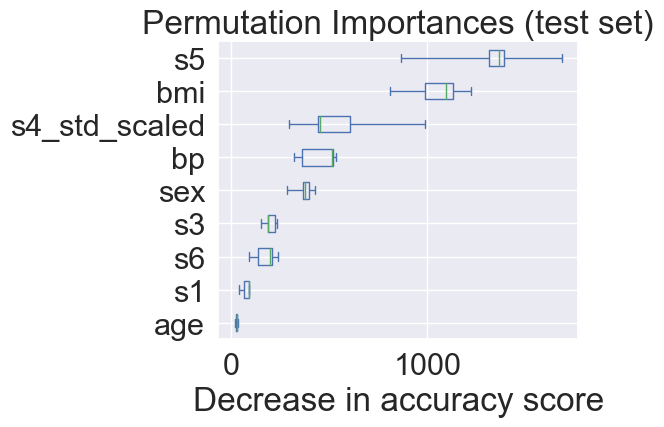

In [51]:

svr_2 = svm.SVR(kernel = "rbf", gamma = 10 , C = 50 , epsilon = 0.1)
svr_2.fit(X_train_filtered_do , y_train_do)
y_pred_2 = svr_2.predict(X_test_filtered_do)
r2  = r2_score(y_test_do, y_pred_2) 
rmse_2  = np.sqrt(mean_squared_error(y_test_do, y_pred_2)) 
result = permutation_importance(svr_2, 
                                X_test_filtered_do, 
                                y_pred_2, 
                                scoring= 'neg_mean_squared_error' , 
                                n_jobs = 1)
sorted_imp_idx = result.importances_mean.argsort()
df_imp = pd.DataFrame(
    result.importances[sorted_imp_idx].T,
    columns = X_train_filtered_do.columns[sorted_imp_idx])
ax = df_imp.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [52]:

r2

0.659146365815748

Above we can see the two most important features are:
<ul>
    <li> <i>bmi</i> : partecipa allo score con un valore al 50 percentile di circa 1250 e influisce sull'MSE in un range di variabilità che arriva anche a raggiungere circa 250 punti rispetto alla mediana</li>
    <li> <i>s5</i> : partecipa allo score con un valore al 50 percentile di circa 1050 e influisce sull'MSE in un range di variabilità che arriva anche a raggiungere circa 200 punti rispetto alla mediana</li>
</ul>
Whereas the less important features are:
<ul>
    <li> <i>age</i>   
    <li> <i>s1</i>  
</ul>
They partecipate with a low decrease in accuracy. 

7.Improvements with Bagging and Boosting
===

7.1 Bagging
---

Bagging use different parallel trained models with different subsets of features and different samples subsets to reduce the variance and avoid overfitting.

Bagging is also characterized by deep trees therefore with high variance.

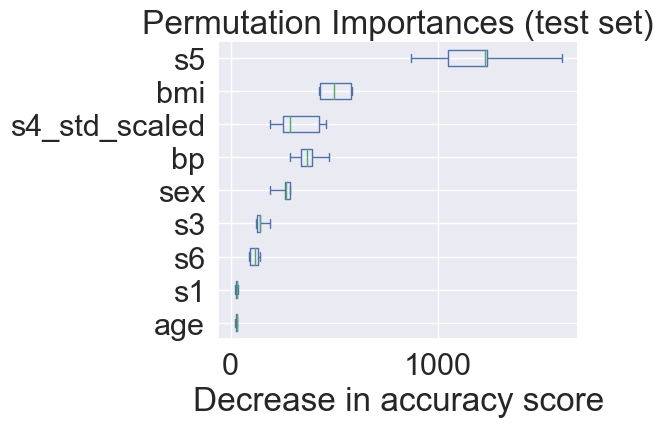

In [53]:
svr_bag = BaggingRegressor(svr_2 , 
                           n_estimators = 60 , 
                           max_features = 0.8 , 
                           random_state = 1,
                           n_jobs = 1 )
svr_bag.fit(X_train_filtered_do , y_train_do)
y_pred_bag = svr_bag.predict(X_test_filtered_do)
mse_bag = mean_squared_error(y_test_do, y_pred_bag)
rmse_bag = np.sqrt(mse_bag)
r2_bag = r2_score(y_test_do, y_pred_bag) 
adj_r2_bag = 1 - ((1 - r2_bag ) * (len(X_train_filtered_do) - 1)/(len(X_train_filtered_do) - X_train_filtered_do.shape[1] - 1))
result_bag = permutation_importance(svr_bag, 
                                X_test_filtered_do, 
                                y_pred_bag, 
                                scoring='neg_mean_squared_error' , 
                                n_jobs = 1)
sorted_imp_idx_bag = result.importances_mean.argsort()
df_imp_bag = pd.DataFrame(
    result_bag.importances[sorted_imp_idx_bag].T,
    columns = X_train_filtered_do.columns[sorted_imp_idx_bag])
ax = df_imp_bag.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [54]:
r2_bag

0.6422314588365154

In [55]:
rmse_bag

47.212254616418875

The Permutation Test allow us to see the effect of randomize one feature and analyze the consequence of how that impact on the model errors.

7.2 Boosting 
---

Boosting algorithm generates a sequence (not in parallel like Bagging) of weak (less deep with hig bias) models and tries to adjust sequentially the prediction errors. The goal in this case is reached working on bias decreasing.

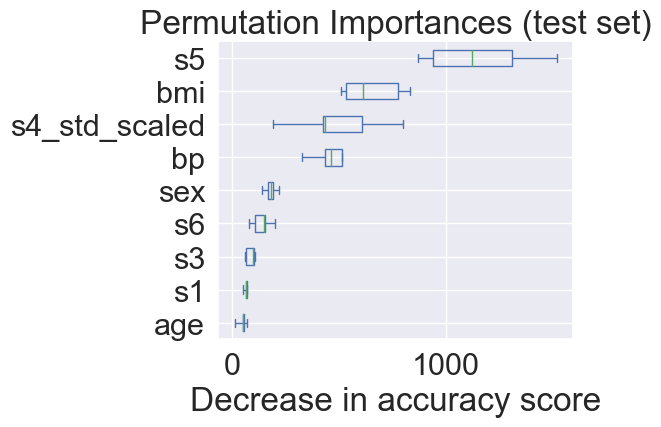

In [56]:
 

svr_boost= AdaBoostRegressor(
                        svr_2,
                        n_estimators = 5,
                        random_state = 1,
                        learning_rate = 1.2
                        )
svr_boost.fit(X_train_filtered_do , y_train_do)
y_pred_boost = svr_boost.predict(X_test_filtered_do) 
mse_boost = mean_squared_error(y_test_do, y_pred_boost)
rmse_boost = np.sqrt(mse_boost)
r2_boost = r2_score(y_test_do, y_pred_boost)
adj_r2_boost = 1 - ((1 - r2_boost ) * (len(X_train_filtered_do) - 1)/(len(X_train_filtered_do) - X_train_filtered_do.shape[1] - 1))
result_boost = permutation_importance(svr_boost, 
                                X_test_filtered_do, 
                                y_pred_bag, 
                                scoring='neg_mean_squared_error' , 
                                n_jobs = 1)
sorted_imp_idx_boost = result_boost.importances_mean.argsort()
df_imp_boost = pd.DataFrame(
    result_boost.importances[sorted_imp_idx_boost].T,
    columns = X_train_filtered_do.columns[sorted_imp_idx_boost])
ax = df_imp_boost.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [57]:
r2_boost

0.6744595478217398

In [58]:
rmse_boost

45.03562007878276

We can conclude that the best approach is *Boosting* because it improves the base model R2's from 0.6591 to 0.6744. 
*Bagging* approach is actually a little worse than the base model score : 0.6479.

Therefore *Boosting* wins.🥳

8.Model convergence results
===

In this section we will try to optimize the parameters one by one to better understand how well each of them is working.

In [59]:
svr = svm.SVR()
par = ["param_C", "param_gamma" , "param_epsilon", "mean_test_score" ,"mean_train_score" , "param_kernel"]
l_SVR_grid = [{'kernel':  ('rbf','poly'), 'C':[ 1 , 10 , 20 , 50 , 200 , 300 , 450 , 600],'gamma': [ 1 , 1],'epsilon':[1 , 1 ]},
              {'kernel':  ('rbf','poly'), 'C':[ 450 , 460 ],'gamma': [ 0.1 , 1 , 1.5 , 3 , 10 , 20 ],'epsilon':[1 , 1 ]},
              {'kernel':  ('rbf','poly'), 'C':[ 450 , 460 ],'gamma': [ 1 , 1],'epsilon':[0.1 , 1 , 10 , 30 , 40 , 50 , 100]}]
l_gs_res = []
l_gs = []
l_res = []

d_score_res = {}
l_score_res = []
for k , par_grid in  enumerate(l_SVR_grid) : 
        l_gs.append(GridSearchCV(svr, 
                        par_grid, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        verbose=0, 
                        n_jobs=1, 
                        refit = True, 
                        return_train_score=True))
        # Weights calculus
        l_gs[k].fit(X_train_filtered_do,y_train_do)
        # Pred calculus
        y_pred = l_gs[k].predict(X_test_filtered_do)
        # Metrics
        mse =  mean_squared_error(y_test_do, y_pred)
        rmse  = np.sqrt(mean_squared_error(y_test_do, y_pred))
        r2  = r2_score(y_test_do, y_pred)
        adj_r2 = 1 - ((1 - r2 ) * (len(X_train_filtered_do) - 1)/
                (len(X_train_filtered_do) - X_train_filtered_do.shape[1] - 1))
        df_res = pd.DataFrame(l_gs[k].cv_results_)
        l_res.append(df_res[par])
        l_score_res.append({  "Best Par" : l_gs[k].best_params_ , "RMSE" : rmse , "AdjR2": adj_r2.round(decimals = 4)})
        
        print(f' Best Par : {l_gs[k].best_params_}   RMSE : {rmse}    R2 : {r2.round(decimals = 4)}    AdjR2 : {adj_r2.round(decimals = 4)} ')
        
  

 Best Par : {'C': 600, 'epsilon': 1, 'gamma': 1, 'kernel': 'rbf'}   RMSE : 47.2795565719747    R2 : 0.6412    AdjR2 : 0.6323 
 Best Par : {'C': 460, 'epsilon': 1, 'gamma': 1, 'kernel': 'rbf'}   RMSE : 47.54220278244902    R2 : 0.6372    AdjR2 : 0.6282 
 Best Par : {'C': 450, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}   RMSE : 47.58917654349661    R2 : 0.6365    AdjR2 : 0.6275 


In [60]:
def plot_model_learning_curve(df , main_par , second_par ):
 
    l_match = [False , False]
    fig = plt.figure( figsize=(8, 6))
    sp1 = sns.scatterplot(x=df[main_par] , y=df['mean_train_score'] , data = df  )
    sp2 = sns.scatterplot(x=df[main_par] , y=df['mean_test_score'] , data = df  ) 
    # Annotate min error 
    max_score = round(df['mean_train_score'].max() , 1)
    plt.annotate(f'{max_score}' , xy=(150,max_score))  
    max_score = round(df['mean_test_score'].max() , 1)
    plt.annotate(f'{max_score}' , xy=(150,max_score))
    # Annotate kernel type for one high and one low score
    for index,(i,j,k) in enumerate(zip(df[main_par],df['mean_train_score'], df['mean_test_score'])):
        if df['mean_train_score'].iloc[index]< -4200 and not l_match[0]:
            plt.annotate(str(df[second_par].iloc[index]), xy=(i,j))
            l_match[0] = True
        elif df['mean_test_score'].iloc[index]< -4200 and not l_match[0]:
            plt.annotate(str(df[second_par].iloc[index]), xy=(i,k))
            l_match[0] = True           
        if df['mean_train_score'].iloc[index] > -3000 and not l_match[1]:
            plt.annotate(str(df[second_par].iloc[index]), xy=(i,j))
            l_match[1] = True
        elif df['mean_test_score'].iloc[index]> -3000 and not l_match[1]:
            plt.annotate(str(df[second_par].iloc[index]), xy=(i,k))
            l_match[1] = True
        if l_match[0] and l_match[1] :
            break  
    plt.title(f' {main_par.replace("param_","")} optimization')
    plt.xlabel(f'{main_par.replace("param_","")}')
    plt.ylabel('MSE error')
    return sp1 , sp2
    

8.1 Parameter C
---

*C* is a regularizaton parameter that act on slack *ξ* ( C x ∑ ξ  ) and weight the sum of the point distance from the support vectors. With *C* we control how much we care about it. The higher is C the more we care.

Therefore *C* acts on error. 

We will consider the best train and test set to see how the model converges on train and test set.

(<AxesSubplot:title={'center':' C optimization'}, xlabel='C', ylabel='MSE error'>,
 <AxesSubplot:title={'center':' C optimization'}, xlabel='C', ylabel='MSE error'>)

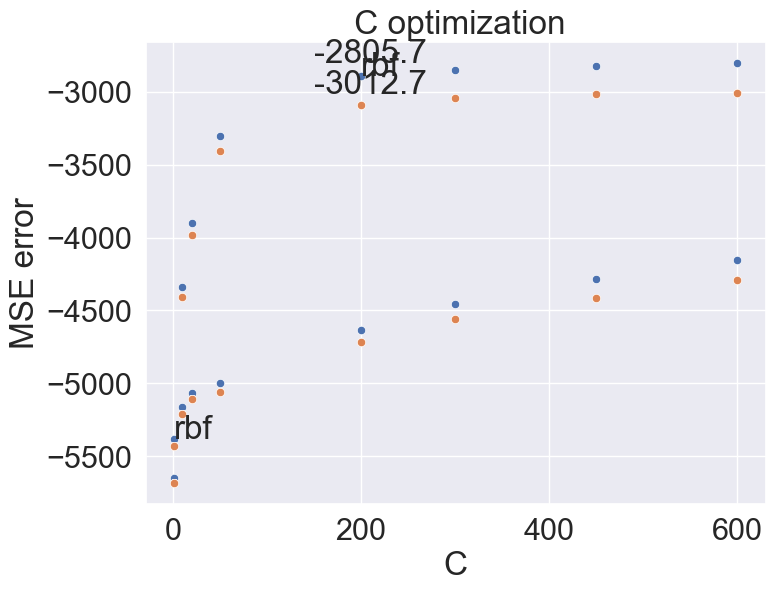

In [61]:
plot_model_learning_curve(df = l_res[0] , main_par = "param_C" , second_par = "param_kernel")

As you can see from the graph above, the lowest MSE values are due to the KERNEL TYPE. *Poly* is the worst, *Rbf* is the best. 
Another thing we can notice is that with the last dataset the lowest MSE is reached.

We can also infere that the discrepancy between the training performance and the test performance diverges as C value grows. 

8.2 Parameter Gamma
---

*Gamma* is = 1/(2*σ^2) is a paramter specific for RBF kernel and control how far the influence of a single training example reaches. The RBF work like the gaussian is mounted on support vectors.  Low values of *Gamma* mean more spread gaussian, higher error and low complexity. High *Gamma* values mean more tight gaussian and more fit to data and more complexity.

(<AxesSubplot:title={'center':' gamma optimization'}, xlabel='gamma', ylabel='MSE error'>,
 <AxesSubplot:title={'center':' gamma optimization'}, xlabel='gamma', ylabel='MSE error'>)

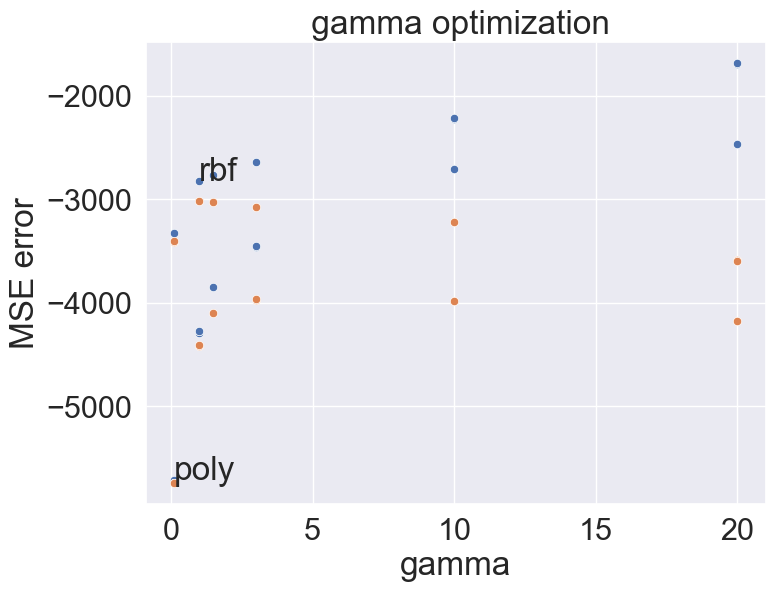

In [62]:
plot_model_learning_curve(df = l_res[1] , main_par = "param_gamma" , second_par = "param_kernel")

The consequences of a growing Gamma parameter are: 
    <ul>
        <li>Train MSE has a positive trend: it gets better as we increase  gamma </li>
        <li>Test MSE  has a negative trend: it gets worse as we increase  gamma </li>
        <li>The behaviour is the same for poly and RBF kernel
    </ul>


8.3 Parameter Epsilon
---

Points inside the tube determined by *ε* distance from the regression line are considered correct. *ε* then defines the margin and the support vectors are defined by data points that lies on or within the margin.

(<AxesSubplot:title={'center':' epsilon optimization'}, xlabel='epsilon', ylabel='MSE error'>,
 <AxesSubplot:title={'center':' epsilon optimization'}, xlabel='epsilon', ylabel='MSE error'>)

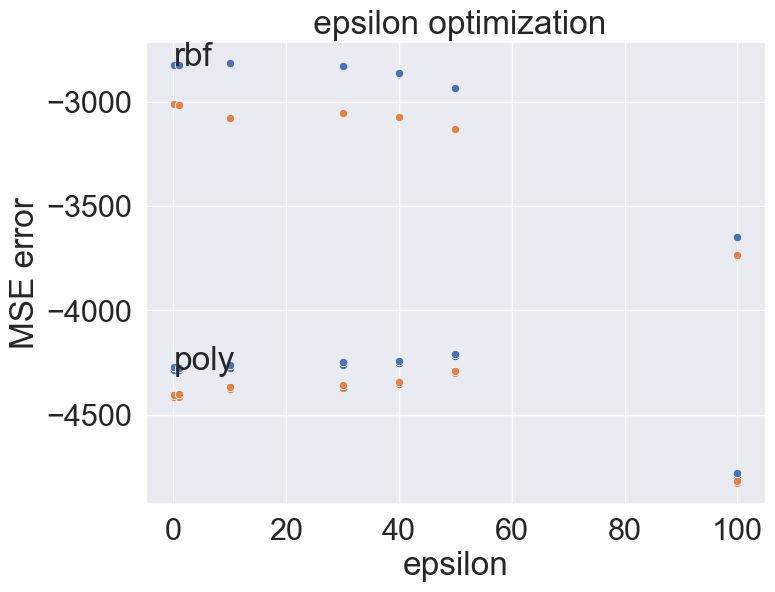

In [63]:
plot_model_learning_curve(df = l_res[2] , main_par = "param_epsilon" , second_par = "param_kernel")

As we increment Epsilon values Train and Test errors delta get lower but the MSE absolute value increases.
<ul>
    <li>Train and Test MSE converges as we increase *gamma*</li>
    <li>The behaviour is opposite for Poly and RBF kernel. With RBF:
        <ul>
            <li> Train MSE has a negative trend: it gets worse as we increase gamma </li>
            <li> Test MSE has a negative trend: it gets worse as we increase gamma </li>
        </ul>
    </li> 
    <li>for Poly kernel:
        <ul>
            <li>Train MSE has a positive trend: it gets better as we increase gamma</li>
            <li>Test MSE  has a positive trend: it gets better as we increase gamma</li>
        </ul>
    </li>       
</ul>

9.Conclusions
===

In [64]:
y_test_do.describe()

count     42.000000
mean     151.095238
std       79.888889
min       42.000000
25%       80.000000
50%      138.000000
75%      229.000000
max      310.000000
Name: target, dtype: float64

Here are the most important insights of this analysis:
<ul>
    <li> FEATURES:
        <ul>
            <li> feature relations are not </li>
            <li> <i>s4</i> can be simplified </li>
            <li> <i>s2</i> can be escluded from the analysis without getting the SVR model any worse </li>
            <li> <i>s5</i> and <i>bmi</i> are the most relevant features </li>
        </ul>
    </li>
    <li> OUTLIERS :
        <ul>
            <li> Quantiles approach to identify outliers didn't help us </li>
            <li> Mahalanobis distance worked really well in outliers identification </li>
        </ul>
    </li>
    <li> ENSEMBLE ALGORITHMS : Boosting is performing better than Bagging algorithm meaning that may be the dataset have high bias problem.   Infact the best test prediction RMSE is 45 and test target has a mean of 151 : the rate is 45/151 = 30% that is quite large. </li>
    <li> MODEL CONVERGENCE: there is a trade off between every SVR parameter value and the total accuracy:
        <ul>
            <li> Kernel : RBF the exponential function wins   </li>
            <li> C  has to be low enough to generalize/regularize the model </li>
            <li> Gamma  has to be low enough to make training weights also good for testset because train and test error diverges </li>
            <li> Epsilon has to be low enough to not generalize too much because train and test errors get lower</li>
        </ul>
    </li>
</ul>